### Import and loading

####  Modules import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import re
from collections import defaultdict
from html.parser import HTMLParser
from itertools import accumulate,chain,takewhile
import warnings
import math

from pathlib import Path,PureWindowsPath,PurePosixPath

#wordcloud
import wordcloud

#pygments
from pygments.lexers import guess_lexer
from pygments.util  import ClassNotFound

# sklearn
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

#gensim
import gensim
import gensim.corpora as corpora

#vis
import pyLDAvis
import pyLDAvis.gensim_models

#nltk
import nltk
from nltk.stem import WordNetLemmatizer

#spacy
import spacy

#bitarray
from  bitarray import bitarray
from  bitarray.util import ba2int

warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


from src import *
from pca import *
# import pca
# import importlib
# importlib.reload(pca)

c:\opt\Anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
c:\opt\Anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(
c:\opt\Anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:43: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(
c:\opt\A

#### Load spacy models

In [2]:
#, disable=["parser", "ner"]
# sp_lite = spacy.load("en_core_web_sm")
sp_full=  spacy.load("en_core_web_trf")


#### Load file

In [3]:
results = "stackOverFlow.csv"
input_file = "QueryResults.csv"
path = PureWindowsPath(r'C:\Users\benjamin.bouchard\Documents\PERSONNEL\OCR\courseNLP\P5')
data = pd.read_csv(f'{path}/{input_file}')

### Data description

#### Simple stats

In [4]:
print(f"Nb questions: {len(data)}.")
data[["Score","ViewCount","FavoriteCount","AnswerCount"]].describe()

Nb questions: 27338.


Score     ViewCount  FavoriteCount   AnswerCount
count  27338.000000  2.733800e+04   27338.000000  27338.000000
mean     113.008523  1.090891e+05      42.724888      7.117236
std      346.850157  2.413333e+05     146.186050      6.735040
min        6.000000  2.610000e+02      11.000000      1.000000
25%       29.000000  2.126625e+04      14.000000      3.000000
50%       51.000000  4.780600e+04      19.000000      5.000000
75%       98.000000  1.094415e+05      35.000000      9.000000
max    26377.000000  9.893978e+06   11586.000000    126.000000

#### Data head

In [5]:
data.head()

Title  \
0  SQL Server 2008 Full Text Search (FTS) versus ...   
1              XML Serialization and Inherited Types   
2                               MyISAM versus InnoDB   
3  Recommended SQL database design for tags or ta...   
4          Specifying a mySQL ENUM in a Django model   

                                                Body  \
0  <p>I know there have been questions in the pas...   
1  <p>Following on from my <a href="https://stack...   
2  <p>I'm working on a projects which involves a ...   
3  <p>I've heard of a few ways to implement taggi...   
4  <p>How do I go about specifying and using an E...   

                                                Tags      Id  Score  \
0  <sql-server><sql-server-2008><full-text-search...  499247     40   
1  <c#><xml><inheritance><serialization><xml-seri...   20084     86   
2     <mysql><database><performance><innodb><myisam>   20148    887   
3  <sql><database-design><tags><data-modeling><ta...   20856    325   
4      <python><mysql><django><django-models><enums>   21454     99   

   ViewCount  FavoriteCount  AnswerCount  
0      18582             26            5  
1      56816             42            7  
2     301985            390           25  
3     118552            307            6  
4      61572             21            9

### Common functions

#### Preprocessing

##### Common

In [6]:
def pipe(df,actions,col):
    """
        Executes list of <actions> on column <col> of dataframe <df>.
        Returns the final result.
    """
    return list(accumulate(iterable=actions, func=lambda s,f: s.apply(f),initial=df[col]))[-1]

lower_str         = lambda x: x.lower()
lower_list        = lambda l: list(map(lower_str,l))

list_2_str  = lambda l: '_'.join(sorted(l))
filter_empty_list = lambda l: list(filter(lambda x: len(x) > 0,l))

def make_sort_list(sorter=None):
    if sorter is not None:
        sort_list  = lambda l: sorted(l,key=sorter)
    else:
        sort_list  = lambda l: sorted(l)
    return sort_list

def make_count_sorter(count):
    sorter = lambda x: count.get(x) if count.get(x) is not None else -1
    return sorter

# binary list to int
list_2_int = lambda b:ba2int(bitarray(b.tolist()))

# def make_remove_pattern_list(signs=None,patterns=None):
#     if signs is None and patterns is None:
#         raise Exception("make_remove_pattern_list: nor signs or patterns is set !")
#     #signs patterns    
#     reg_exp0 = "[" + ' | '.join(signs)+ "]" if signs    is not None else ""
#     #other patterns
#     reg_exp1 =       ' | '.join(patterns)   if patterns is not None else "" 
#     #merge patterns
#     merge_patterns = lambda a,b: b if a == "" else (a if b == "" else a + " | " + b)
#     reg_exp = merge_patterns(reg_exp0,reg_exp1)
#     print(reg_exp)
#     p = re.compile(reg_exp)
#     #returned function
#     list_filter = lambda l: list(map(lambda x: re.sub(p,"",x),l))
#     return list_filter

def make_remove_list(pattern,rpl,exceptions):
    reg_exp = re.compile(pattern)
    #returned function
    list_filter = lambda l: list(
        map(lambda x: 
            re.sub(reg_exp,rpl,x) if x not in exceptions else x,
            l
            )
        )
    return list_filter

def make_remove_signs_str(signs=None):
    if signs is None:
        raise Exception("make_remove_signs_str: signs is not set !")
    #signs patterns    
    pattern = "[" + ' | '.join(signs)+ "]"
    reg_exp = re.compile(pattern)
    f = lambda str: re.sub(reg_exp," ",str)
    return f

def make_remove_signs_list(signs=None,rpl="",exceptions=[]):
    if signs is None:
        raise Exception("make_remove_signs_list: signs is not set !")
    #signs patterns    
    pattern = "[" + ' | '.join(signs)+ "]"
    return make_remove_list(pattern,rpl,exceptions)

def make_remove_patterns_list(patterns=None,rpl="",exceptions=[]):
    if patterns is None:
        raise Exception("make_remove_patterns_list: patterns is not set !")
    #reg exp from patterns
    pattern = ' | '.join(patterns) 
    return make_remove_list(pattern,rpl,exceptions)

def make_filter_list(exclude=None,include=None):
    # not working ??
    #cond = lambda x: x not in exclude if exclude is not None else ( (lambda x: x in include) if include is not None else (lambda x: True))
    if exclude is not None and include is not None:
        raise Exception("make_filter_list: both exclude and include are set !")
    if exclude is None and include is None:
        return  lambda l: l
    else:
        if exclude is not None:
            cond = lambda x: x not in exclude
        else:
            cond = lambda x: x in include
        return lambda l: list(filter(cond,l)) 

def make_tokenizer_list(pattern):
    reg_exp = re.compile(pattern)
    def split(acc,x):
        acc.extend(reg_exp.split(x))
        return acc
    def tokenizer(l):
         return list(accumulate(l,split,initial=[]))[-1]
    return tokenizer

def make_extractor_pattern_str(pattern):
    regexp = re.compile(pattern)
    def extractor(x):
        return regexp.findall(x)
    return extractor     

def merge_tokens(df,cols):
    """ merge list (tokens) contained in cols of df """
    merger = lambda r: list(chain(*[r[k] for k in cols]))
    return df.apply(merger,axis=1)

def count_tokens(df,col,term_count=True,term_freq=False,doc_freq=False,out_df=False):
    """ count tokens contain in col of dataframe df """
    if term_freq == doc_freq == term_count:
        raise Exception("count_tokens: term_freq and doc_freq are equal !")

    out_col = 'count'    
    counter = defaultdict(int)
    def inc(x):
        counter[x] += 1

    if term_freq == True:
        out_col = 'term_freq'
        df[col].apply(
            lambda l: list(
                map(lambda x: inc(x),l)
            )
        )

    if doc_freq == True:
        out_col = 'doc_freq'
        df[col].apply(
            lambda l: list(
                map(lambda x: inc(x),set(l))  # remove duplicates set(l)
            )
        )

    if (term_freq is True or doc_freq is True):
        N = sum(counter.values())  if term_freq == True else len(df[col])
        ret= {k:v/N for (k,v) in counter.items()}
    else:
        ret = counter

    if out_df == True:
        return pd.DataFrame(ret.items(),columns=['tokens',out_col])
    else:
        return ret

def filter_term_docfreq(df,col,max=1.0,min=0.0):
    """
        filter-out terms that have doc frequency less than min and more than max
    """
    counts = count_tokens(df,col,doc_freq=True)
    return df[col].apply(make_filter_list(include=[k for (k,v) in counts.items() if v > min and v < max]))        

##### Stop words

In [7]:
# merge stops words from different sources
# https://www.ranks.nl/stopwords
rank_nl= ["able","about","above","abst","accordance","according","accordingly","across","act","actually","added","adj","affected","affecting","affects","after","afterwards","again","against","ah","all","almost","alone","along","already","also","although","always","am","among","amongst","an","and","announce","another","any","anybody","anyhow","anymore","anyone","anything","anyway","anyways","anywhere","apparently","approximately","are","aren","arent","arise","around","as","aside","ask","asking","at","auth","available","away","awfully","b","back","be","became","because","become","becomes","becoming","been","before","beforehand","begin","beginning","beginnings","begins","behind","being","believe","below","beside","besides","between","beyond","biol","both","brief","briefly","but","by","c","ca","came","can","cannot","can't","cause","causes","certain","certainly","co","com","come","comes","contain","containing","contains","could","couldnt","d","date","did","didn't","different","do","does","doesn't","doing","done","don't","down","downwards","due","during","e","each","ed","edu","effect","eg","eight","eighty","either","else","elsewhere","end","ending","enough","especially","et","et-al","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","except","f","far","few","ff","fifth","first","five","fix","followed","following","follows","for","former","formerly","forth","found","four","from","further","furthermore","g","gave","get","gets","getting","give","given","gives","giving","go","goes","gone","got","gotten","h","had","happens","hardly","has","hasn't","have","haven't","having","he","hed","hence","her","here","hereafter","hereby","herein","heres","hereupon","hers","herself","hes","hi","hid","him","himself","his","hither","home","how","howbeit","however","hundred","i","id","ie","if","i'll","im","immediate","immediately","importance","important","in","inc","indeed","index","information","instead","into","invention","inward","is","isn't","it","itd","it'll","its","itself","i've","j","just","k","keep	keeps","kept","kg","km","know","known","knows","l","largely","last","lately","later","latter","latterly","least","less","lest","let","lets","like","liked","likely","line","little","'ll","look","looking","looks","lot","ltd","m","made","mainly","make","makes","many","may","maybe","me","mean","means","meantime","meanwhile","merely","mg","might","million","miss","ml","more","moreover","most","mostly","mr","mrs","much","mug","must","my","myself","n","na","name","namely","nay","nd","near","nearly","necessarily","necessary","need","needs","neither","never","nevertheless","new","next","nine","ninety","no","nobody","non","none","nonetheless","noone","nor","normally","nos","not","noted","nothing","now","nowhere","o","obtain","obtained","obviously","of","off","often","oh","ok","okay","old","omitted","on","once","one","ones","only","onto","or","ord","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","owing","own","p","page","pages","part","particular","particularly","past","per","perhaps","placed","please","plus","poorly","possible","possibly","potentially","pp","predominantly","present","previously","primarily","probably","promptly","proud","provides","put","q","que","quickly","quite","qv","r","ran","rather","rd","re","readily","really","recent","recently","ref","refs","regarding","regardless","regards","related","relatively","research","respectively","resulted","resulting","results","right","run","s","said","same","saw","say","saying","says","sec","section","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sent","seven","several","shall","she","shed","she'll","shes","should","shouldn't","show","showed","shown","showns","shows","significant","significantly","similar","similarly","since","six","slightly","so","some","somebody","somehow","someone","somethan","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specifically","specified","specify","specifying","still","stop","strongly","sub","substantially","successfully","such","sufficiently","suggest","sup","sure	t","take","taken","taking","tell","tends","th","than","thank","thanks","thanx","that","that'll","thats","that've","the","their","theirs","them","themselves","then","thence","there","thereafter","thereby","thered","therefore","therein","there'll","thereof","therere","theres","thereto","thereupon","there've","these","they","theyd","they'll","theyre","they've","think","this","those","thou","though","thoughh","thousand","throug","through","throughout","thru","thus","til","tip","to","together","too","took","toward","towards","tried","tries","truly","try","trying","ts","twice","two","u","un","under","unfortunately","unless","unlike","unlikely","until","unto","up","upon","ups","us","use","used","useful","usefully","usefulness","uses","using","usually","v","value","various","'ve","very","via","viz","vol","vols","vs","w","want","wants","was","wasnt","way","we","wed","welcome","we'll","went","were","werent","we've","what","whatever","what'll","whats","when","whence","whenever","where","whereafter","whereas","whereby","wherein","wheres","whereupon","wherever","whether","which","while","whim","whither","who","whod","whoever","whole","who'll","whom","whomever","whos","whose","why","widely","willing","wish","with","within","without","wont","words","world","would","wouldnt","www","x","y","yes","yet","you","youd","you'll","your","youre","yours","yourself","yourselves","you've","z","zero"]

# stop words sources
stopwords_sources = [wordcloud.STOPWORDS,nltk.corpus.stopwords.words('english'),sp_full.Defaults.stop_words,rank_nl]

def merge_stop_words(*args):
    return list(set(chain(*args)))

__STOPWORDS__ = sorted(merge_stop_words(*stopwords_sources))
print(__STOPWORDS__)

["'d", "'ll", "'m", "'re", "'s", "'ve", 'a', 'able', 'about', 'above', 'abst', 'accordance', 'according', 'accordingly', 'across', 'act', 'actually', 'added', 'adj', 'affected', 'affecting', 'affects', 'after', 'afterwards', 'again', 'against', 'ah', 'ain', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amount', 'an', 'and', 'announce', 'another', 'any', 'anybody', 'anyhow', 'anymore', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'apparently', 'approximately', 'are', 'aren', "aren't", 'arent', 'arise', 'around', 'as', 'aside', 'ask', 'asking', 'at', 'auth', 'available', 'away', 'awfully', 'b', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'begin', 'beginning', 'beginnings', 'begins', 'behind', 'being', 'believe', 'below', 'beside', 'besides', 'between', 'beyond', 'biol', 'both', 'bottom', 'brief', 'briefly', 'but', 'by', 'c', 'ca', 'call', 'came', 'can', "can't", 'can

##### Guess code language

In [8]:
reg_exp_lexer = re.compile("<class 'pygments.lexers.(.*)'>")
def guess_code_language(acc,code):
    try:
        guess = guess_lexer(code)
        t = str(type(guess))
        lexer = reg_exp_lexer.findall(t)[0]
        if lexer == 'special.TextLexer':
            acc['text'].append(code)
        else:
            acc['lexer'].append(lexer)
    except ClassNotFound as e:
        pass
    except BaseException as err:
        print(f"Error: code: {code} - type:{t} - Exception: {err}")
    return acc

handle_code_section = lambda l : list(accumulate(l,guess_code_language,initial={'text':[],'lexer':[]}))[-1]

##### Html Parser

In [9]:
class Strcontainer:

    def __init__(self):
        self.content = ""

    def add(self,tag,data):
        self.content += data
    
    def clear(self):
        self.content = ""

    def copy(self):
        return self.content


class DefaultListcontainer:

    def __init__(self):
        self.content = defaultdict(list)

    def add(self,tag,data):
        self.content[tag].append(data)
    
    def clear(self):
        self.content.clear()

    def copy(self):
        return self.content.copy()

class MyHTMLParser(HTMLParser):
    """
        Html parser to parse Body field.
        Note that Body is not fully-compliant html.
    """
    def __init__(self,filter,container=DefaultListcontainer):
        self.tags    = []
        self.filter  = filter
        #self.content = defaultdict(list)
        self.content = container
        self.single_tags = ['br','img','hr'] 
        super().__init__() 

    def pop_stack(self,tag):
        N = len(self.tags)
        if  N > 0:
            try:
                j = list(reversed(self.tags)).index(tag)    
                i = N - 1 - j
                self.tags.remove(i)
            except:
                pass

    def handle_starttag(self, tag, attrs):
        if tag not in self.single_tags:
            #print("Encountered a start tag:", tag)
            self.tags.append(tag)

    def handle_endtag(self, tag):
        if tag not in self.single_tags:
            #print("Encountered an end tag :", tag)
            self.pop_stack(tag)
            #top_tag = self.tags.pop()
            #assert top_tag == tag, f"Error when unstacking tag (seen tag: {tag} <> unstacked tag: {top_tag})"

    def handle_data(self, data):
        top_tag = self.tags[-1] if len(self.tags) > 0 else 'NO_TAG'
        if( not(self.filter(top_tag)) ):
            #self.content[top_tag].append(data)
            self.content.add(data)
            #print("Encountered some data  :", data)
    
    def clear(self):
        self.content.clear()
        self.tags.clear()
        self.reset()

def do_parse(x,html_parser):
    """
        Clear and feed html parser.
        Function to be called in pipe to treat the full dataset
    """
    html_parser.clear()
    try:
        html_parser.feed(x)
    except:
        print(f"EXCEPTION:{x}")
    return html_parser.content.copy()    

def make_extractor_keys(exclude=None,include=None):
    """
        helping function used in  make_keys_getter
    """
    if include is None and exclude is not None:
        def extractor(acc,item):
            (k,v) = item
            if k not in exclude:
                acc.extend(v)
            return acc
    elif exclude is None and include is not None:
        def extractor(acc,item):
            (k,v) = item
            if k in include:
                acc.extend(v)
            return acc
    else:
        def extractor(acc,item):
            (k,v) = item
            acc.extend(v)
            return acc
    return extractor

def make_keys_getter(exclude=None,include=None):
    """
        extract keys in dict returned by html parser
    """
    extractor_keys = make_extractor_keys(exclude,include)
    return lambda x : list(accumulate(x.items(),extractor_keys,initial=[]))[-1]

In [10]:
#used in 
# merge_patterns = lambda a,b: b if a == "" else (a if b == "" else a + " | " + b)
# assert merge_patterns("a","b") == 'a | b' 
# assert merge_patterns("a","") == 'a'
# assert merge_patterns("","b") == 'b'

#make_filter_list
assert (make_filter_list(include=['a'])(['a','b','c']) == ['a'] )
assert (make_filter_list(exclude=['c'])(['a','b','c']) == ['a','b'] )

# #list_2_int
# barrays =np.array([
#     [0,0,0,0],
#     [0,0,0,1],
#     [0,0,1,0],
#     [0,1,0,0],
#     [1,0,0,0],
#     [1,0,0,1],
#     [0,1,1,0],
#     [1,1,1,1],
# ])
# barrays_int = [0,1,2,4,8,9,6,15]
# assert list(map(list_2_int,barrays)) == barrays_int

#### Lemmatization

In [11]:
# reference: https://stackoverflow.com/questions/5364493/lemmatizing-pos-tagged-words-with-nltk
from nltk.corpus import wordnet as wn
tag_map = {
        'CC':None, # coordin. conjunction (and, but, or)  
        'CD':wn.NOUN, # cardinal number (one, two)             
        'DT':None, # determiner (a, the)                    
        'EX':wn.ADV, # existential ‘there’ (there)           
        'FW':None, # foreign word (mea culpa)             
        'IN':wn.ADV, # preposition/sub-conj (of, in, by)   
        'JJ':[wn.ADJ, wn.ADJ_SAT], # adjective (yellow)                  
        'JJR':[wn.ADJ, wn.ADJ_SAT], # adj., comparative (bigger)          
        'JJS':[wn.ADJ, wn.ADJ_SAT], # adj., superlative (wildest)           
        'LS':None, # list item marker (1, 2, One)          
        'MD':None, # modal (can, should)                    
        'NN':wn.NOUN, # noun, sing. or mass (llama)          
        'NNS':wn.NOUN, # noun, plural (llamas)                  
        'NNP':wn.NOUN, # proper noun, sing. (IBM)              
        'NNPS':wn.NOUN, # proper noun, plural (Carolinas)
        'PDT':[wn.ADJ, wn.ADJ_SAT], # predeterminer (all, both)            
        'POS':None, # possessive ending (’s )               
        'PRP':None, # personal pronoun (I, you, he)     
        'PRP$':None, # possessive pronoun (your, one’s)    
        'RB':wn.ADV, # adverb (quickly, never)            
        'RBR':wn.ADV, # adverb, comparative (faster)        
        'RBS':wn.ADV, # adverb, superlative (fastest)     
        'RP':[wn.ADJ, wn.ADJ_SAT], # particle (up, off)
        'SYM':None, # symbol (+,%, &)
        'TO':None, # “to” (to)
        'UH':None, # interjection (ah, oops)
        'VB':wn.VERB, # verb base form (eat)
        'VBD':wn.VERB, # verb past tense (ate)
        'VBG':wn.VERB, # verb gerund (eating)
        'VBN':wn.VERB, # verb past participle (eaten)
        'VBP':wn.VERB, # verb non-3sg pres (eat)
        'VBZ':wn.VERB, # verb 3sg pres (eats)
        'WDT':None, # wh-determiner (which, that)
        'WP':None, # wh-pronoun (what, who)
        'WP$':None, # possessive (wh- whose)
        'WRB':None, # wh-adverb (how, where)
        '$':None, #  dollar sign ($)
        '#':None, # pound sign (#)
        '“':None, # left quote (‘ or “)
        '”':None, # right quote (’ or ”)
        '(':None, # left parenthesis ([, (, {, <)
        ')':None, # right parenthesis (], ), }, >)
        ',':None, # comma (,)
        '.':None, # sentence-final punc (. ! ?)
        ':':None # mid-sentence punc (: ; ... – -)
    }
def pos_tagger(nltk_tag):
    return tag_map.get(nltk_tag)

In [12]:
def make_lemmatizer(allowed_postags=['VB','VBD','VBG','VBN','VBP','VBZ','NN','NNS','NNP','NNPS']):
    wnl = WordNetLemmatizer()
    lemmatizer = lambda doc: [ 
        wnl.lemmatize(token,pos_tagger(nltk_tag)) if nltk_tag in allowed_postags else ''
        for (token,nltk_tag) in nltk.pos_tag(doc)   
    ]
    return lemmatizer

In [13]:
# def make_lemmatizer(sp,allowed_postags):
#     def lemmatizer(tokens):
#         #doc = Doc(vocab=sp.vocab,words=tokens)
#         doc = sp(' '.join(tokens))
#         return [token.lemma_ for token in doc if token.pos_ in allowed_postags]
#     return lemmatizer

# def lemmatization(df,col,sp,allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
#     """"  
#         Lemmatize the column col in dataframe df using the spacy model sp.
#         Only POS corresponding to allowed_postags are lemmatized (thus others are filtered out).
#     """
#     lemmatize = make_lemmatizer(sp,allowed_postags)
#     return df[col].apply(lemmatize)

#### Display

##### Wordcloud

In [14]:
def display_word_cloud(data,col,max_words=None):

    freq = count_tokens(data,col,doc_freq=True)
    max_words = len(freq.keys()) if max_words is None else max_words
    wc = wordcloud.WordCloud(
        random_state=8,
        normalize_plurals=False,
        width=1800,height=600,
        max_words=max_words,
        stopwords=[]
    )

    wc.generate_from_frequencies(freq)

    # create a figure
    fig, ax = plt.subplots(1,1, figsize = (25,12))
    # add interpolation = bilinear to smooth things out
    plt.imshow(wc, interpolation='bilinear')
    # and remove the axis
    plt.axis("off")

In [15]:
def display_corpus_stat(data,col,name):
    print(f"===== Document frequencies of {name} corpus' tokens =====")
    m=100
    doc_freq = count_tokens(data,col,doc_freq=True,out_df=True)
    print(f"{name} corpus contains {len(doc_freq)} tokens.")
    print(f"One doc freq is {round(m/len(data),4)} (%).")
    doc_freq['doc_freq'] = m*doc_freq['doc_freq']
    print(doc_freq.describe())
    univariate_num(m*doc_freq['doc_freq'],filters=['1.5*IQR','3*IQR','5*IQR'])

In [16]:
#p% of tags' usage for n most used tags
tokens_usage  = lambda tokens,n,col: tokens.nlargest(n,col)[col].sum()/tokens[col].sum()

# nb of tokens required to get p% (0<p<=1) of tokens' usage
nb_tokens_for_coverage = lambda stats,p,col: list(takewhile(lambda k: tokens_usage(stats,k,col) < p,range(len(stats))))[-1]+1

n_most_used_tokens = lambda n,data,col:count_tokens(data,col,doc_freq=True,out_df=True).nlargest(n,'doc_freq')
n_less_used_tokens = lambda n,data,col:count_tokens(data,col,doc_freq=True,out_df=True).nsmallest(n,'doc_freq')

def tokens_coverage(data,col,ns):
    stats_termf = count_tokens(data,col,term_freq=True,out_df=True)
    stats_docf = count_tokens(data,col,doc_freq=True,out_df=True)
    # 
    ns = sorted(list(map(lambda p: nb_tokens_for_coverage(stats_docf,p,'doc_freq'),np.arange(0.1,1.0,0.1))) + ns)
    #
    usage = lambda stats,col: list(map(lambda n: tokens_usage(stats,n,col),ns))
    # return pd.DataFrame(
    #     data={'n most used tokens':ns,'total usage':usage(stats_termf,'term_freq'),'doc coverage':usage(stats_docf,'doc_freq')}
    # )
    return pd.DataFrame(
        data={'n most used tokens':ns,'total usage':usage(stats_termf,'term_freq')}
    )


def histo_n_most_used(data,col,n,figsize_=(25,50)):
    stat_col = 'doc_freq'
    n_most_used_tokens = count_tokens(data,col,doc_freq=True,out_df=True).nlargest(n,stat_col)
    N = 50                             # number of tokens per ax
    p = 4                              # number of ax per row
    m = math.ceil(math.ceil(n/N)/p)    # number of rows needed
    fig, axs = plt.subplots(nrows=m, ncols=p, figsize=figsize_,constrained_layout=True,sharey=False)
    
    z = list(zip(list(range(0,n,N)),list(range(N,n,N))))
    if n%N != 0:
        end = z[-1] if len(z) > 0 else (0,0)
        z.append((end[1],n))

    for ((start,end),ax) in zip(z,chain(*axs) if len(axs.shape) == 2 else axs):
        _ = n_most_used_tokens.iloc[start:end,:].plot(kind="bar",x="tokens",y=stat_col,ax=ax)

def df_docCount_nmost_used(d,col,ids):
    c = count_tokens(d,col,doc_freq=True,out_df=True).sort_values(by=['doc_freq'],ascending=False).iloc[ids,:]
    c['doc count'] = len(d)*c['doc_freq']
    c['n most used tokens'] = ids
    return c.loc[:,['n most used tokens','doc_freq','doc count']]

In [17]:
def BOW_vectorizer(tokens,vectorizer_ctor,**args):
    Id = lambda x: x
    # skip preprocessing and tokenizing steps
    vectorizer = vectorizer_ctor(preprocessor=Id,tokenizer=Id,lowercase=False,**args)
    X = vectorizer.fit_transform(tokens)
    return (X,vectorizer)


In [18]:
def display_pca(data,body_min,body_max,title_min,title_max,col_body='body-tokens'):
    data['filtered-body-tokens'] = filter_term_docfreq(data,col_body,min=body_min,max=body_max)
    data['filtered-title-tokens'] = filter_term_docfreq(data,'title-tokens',min=title_min,max=title_max)
    data['tokens'] = merge_tokens(data,['filtered-body-tokens','filtered-title-tokens'])
    (values,_) = BOW_vectorizer(data['tokens'],CountVectorizer)
    pca_df = pd.DataFrame(data=values.toarray())
    (pca,_) = do_pca(pca_df)
    print(f"body_min: {body_min} - body_max: {body_max} - title_min: {title_min} - title_max: {title_max}")
    print(f'pca.shape: {pca_df.shape}')
    display_scree_plot(pca)
    data.drop(columns=['tokens','filtered-body-tokens','filtered-title-tokens'],inplace=True)

def display_scree_plot(pca,figsize_=(36,12),N=5):
    take_one_every = lambda l,n: list(map(lambda i: l[i],range(0,len(l),n)))
    csum = (pca.explained_variance_ratio_*100).cumsum()
    scree = np.array(take_one_every(csum,N))
    xs = N*(np.arange(len(scree)))   
    # add last point
    np.append(scree,csum[-1])
    np.append(xs,len(csum))
    _,ax = plt.subplots(figsize=figsize_)
    ax.plot(xs, scree,c="red",marker='o',alpha=1)
    ax.set_ylim(ymin=0.0)
    ax.set_xlim(xmin=0.0,xmax=max(xs))
    ax.set_xticks(ticks=xs,labels=xs,rotation=90.0)
    ax.set_yticks(range(0,105,5))
    ax.grid(True)
    plt.xlabel("Rang de l'axe d'inertie")
    plt.ylabel("Pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

## Data Processing

### Tags Processing

In [19]:
# normalize tags
data['ntags'] = pipe(data,[make_extractor_pattern_str("\\<([a-z, A-Z, 0-9,\\-,\\+,#]*)\\>"),lower_list],col='Tags')

#### <s>Tags counting</s>

In [20]:
# tag_stats = count_tokens(data,"ntags",doc_freq=True)
# tags = pd.DataFrame(tag_stats.items(),columns=['tag','count'])

#### <s>Tags sorting</s>

In [21]:
# sorter = make_count_sorter(tag_stats)
# data['ntags'] = pipe(data,[make_sort_list(sorter),lower_list],col='ntags')

#### Tags stats

##### display_corpus_stat

===== Document frequencies of Tags corpus' tokens =====
Tags corpus contains 11993 tokens.
One doc freq is 0.0037 (%).
           doc_freq
count  11993.000000
mean       0.039673
std        0.270657
min        0.003658
25%        0.003658
50%        0.007316
75%        0.018290
max       11.248080


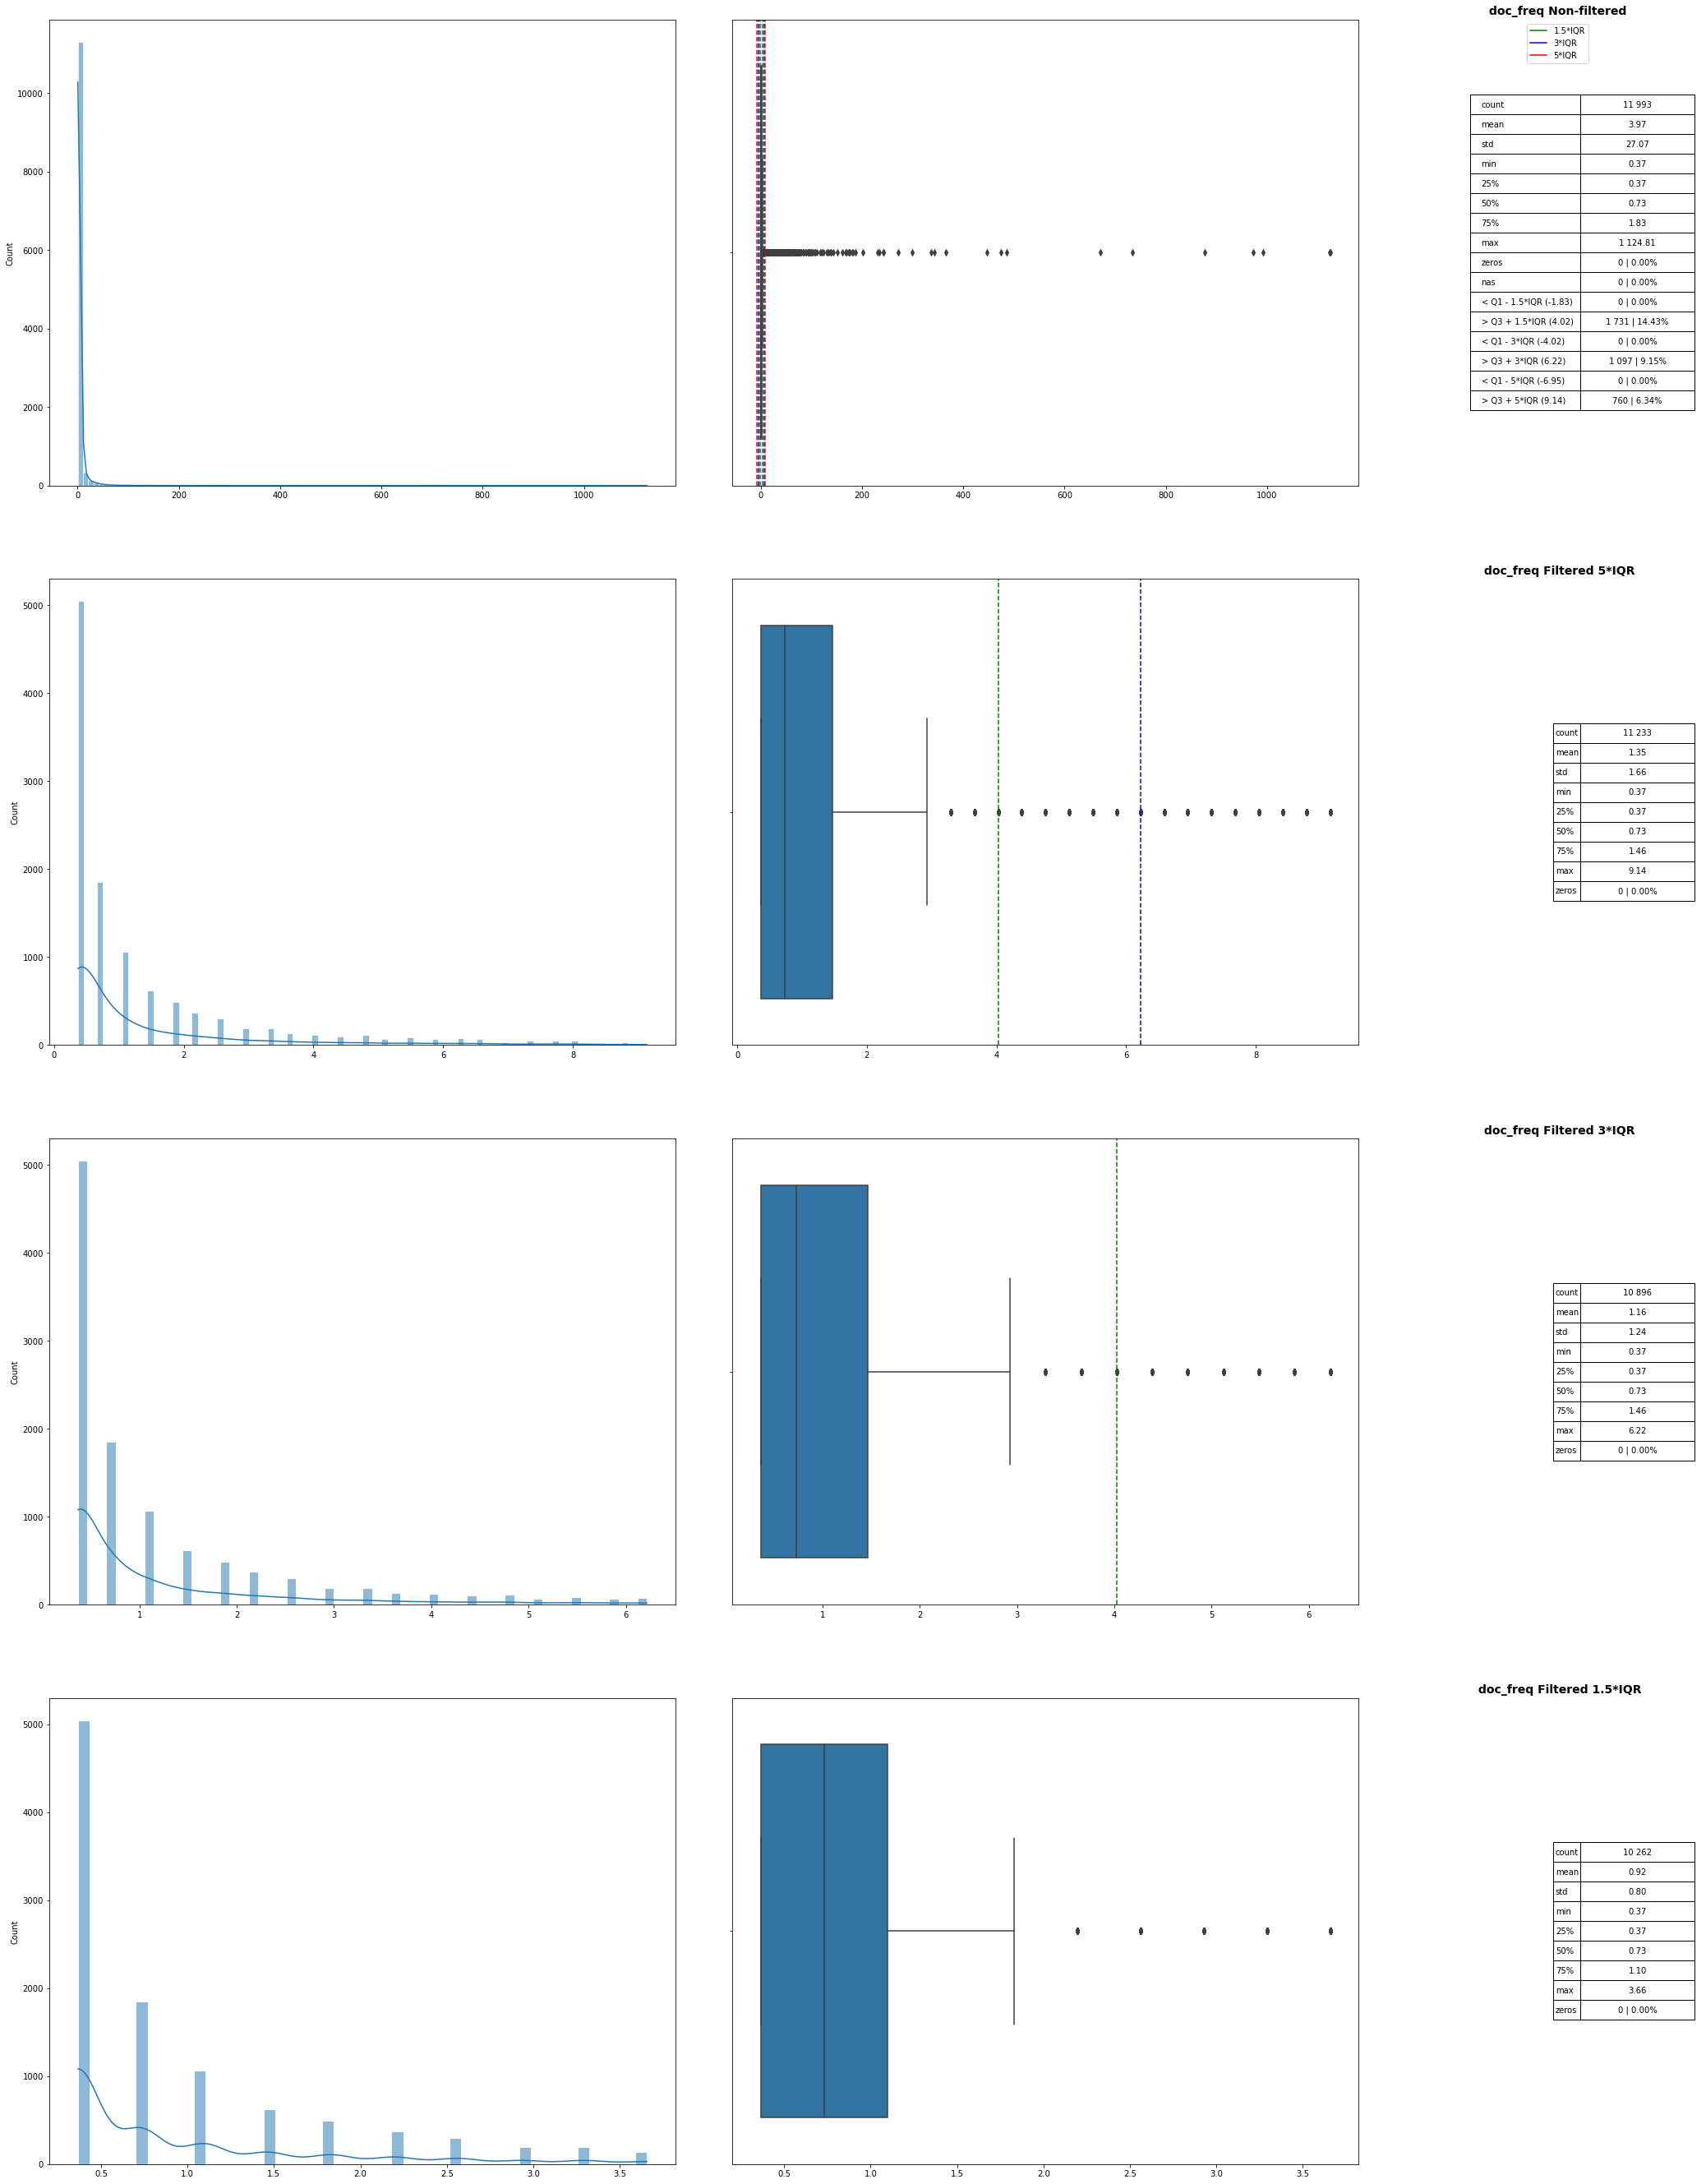

In [22]:
display_corpus_stat(data,'ntags','Tags')

##### tokens_coverage

In [79]:
tokens_coverage(data,'ntags',ns=[50,100,500,1000])

n most used tokens  total usage
0                    5     0.106984
1                   15     0.200046
2                   45     0.301172
3                   50     0.311789
4                  100     0.387699
5                  111     0.400215
6                  232     0.500058
7                  446     0.600038
8                  500     0.617867
9                  866     0.700019
10                1000     0.721384
11                1714     0.800085
12                3765     0.900012

In [76]:
tmp['doc_freq'].sum()

4.758029116980028

In [ ]:

tmp = count_tokens(data,'ntags',doc_freq=True,out_df=True)


In [27]:
import joblib
joblib.dump(value=tmp.nlargest(100,'doc_freq')['tokens'].values,filename='./tags.joblib')

['./tags.joblib']

In [72]:
tokens_usage  = lambda tokens,n,col: tokens.nlargest(n,col)[col].sum()
tokens_usage(tmp,3,'doc_freq')

0.3240178506108713

##### histo_n_most_used

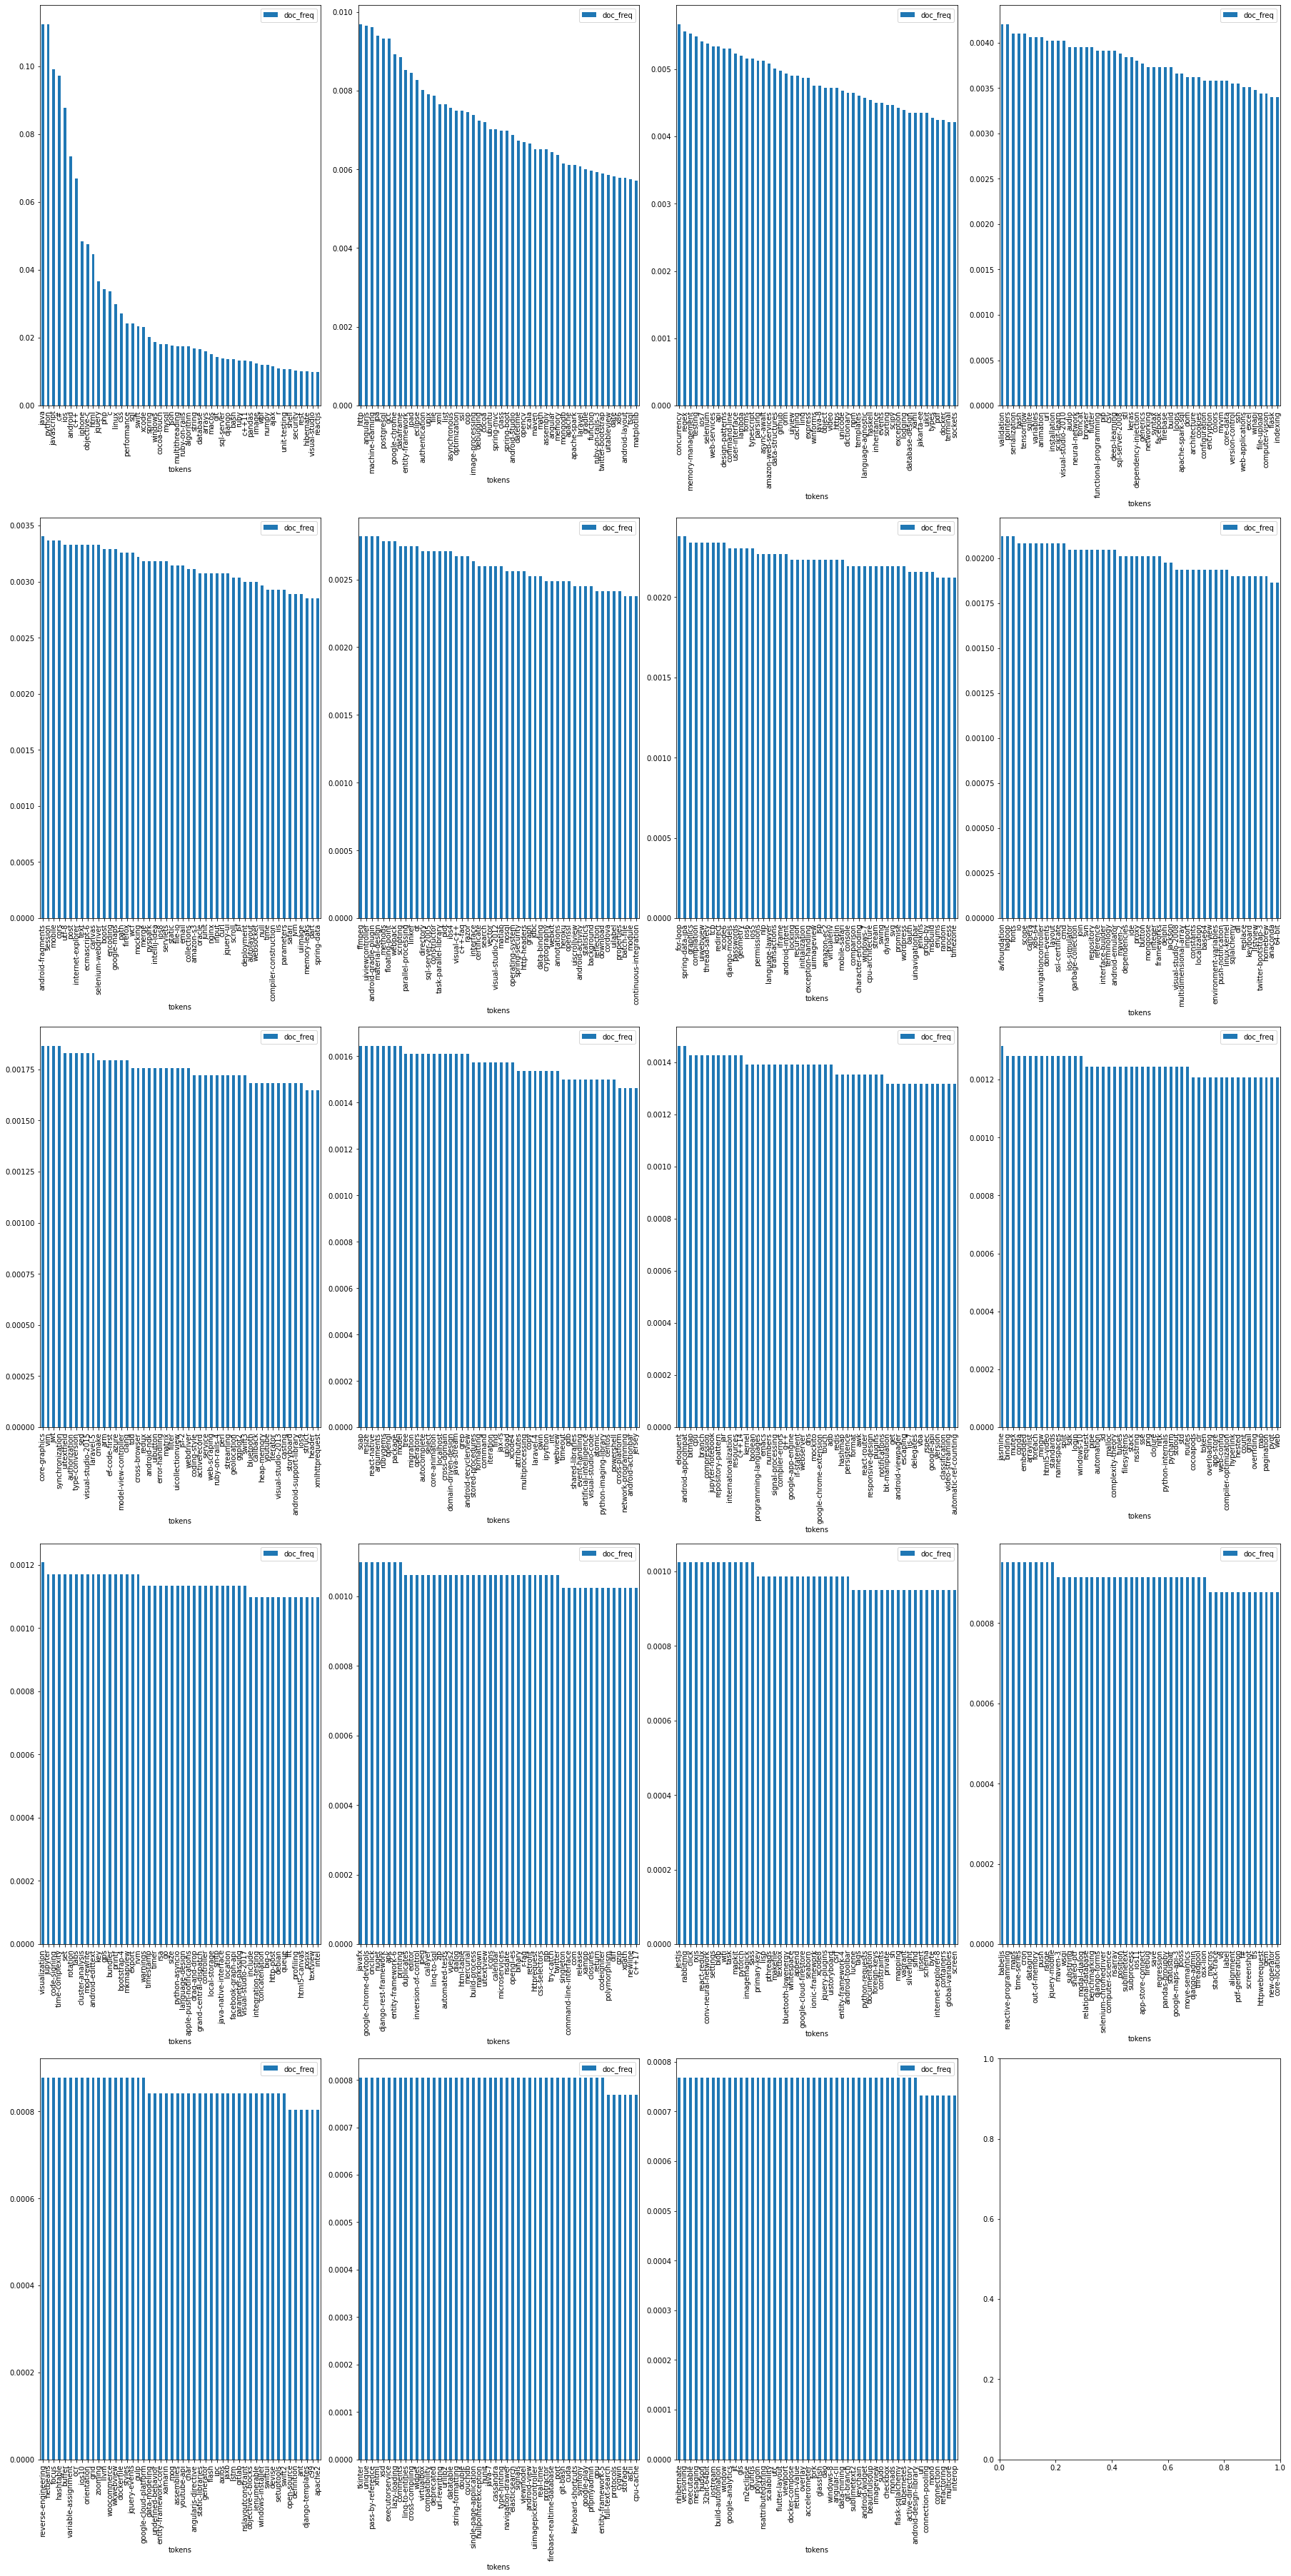

In [24]:
histo_n_most_used(data,'ntags',n=1000)

##### display_word_cloud

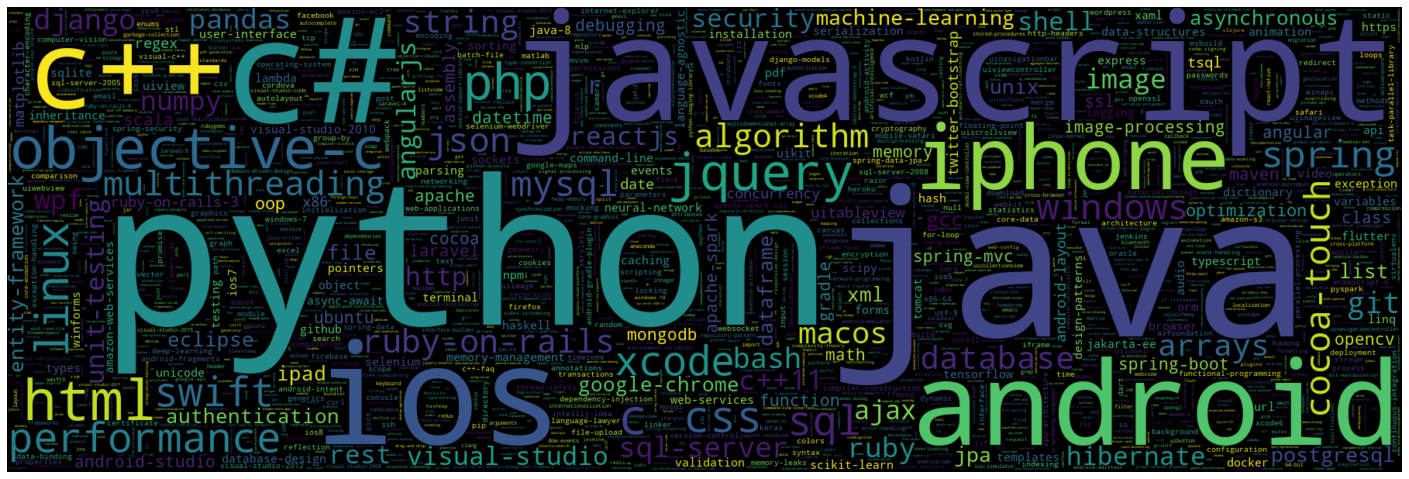

In [25]:
display_word_cloud(data,"ntags")

#### Tags usage

In [26]:
# #p% of tags' usage for n most used tags
# tags_usage    = lambda tags,n: tags.nlargest(n,'count')['count'].sum()/tags['count'].sum()

# # nb of tags required to get p% (0<p<=1) of tags' usage
# nb_tags_for_coverage = lambda tags,p: list(takewhile(lambda k: tags_usage(tags,k) < p,range(len(tags))))[-1]+1

# def n_tags_display(tags,n,figsize_=(25,50)):
#     n_most_used_tags = tags.nlargest(n,'count')
#     print(f"{n} most used tags ({round(100*n/len(tags),2)}% of total tags) represent {round(100*(n_most_used_tags['count'].sum()/tags['count'].sum()),2)} % of tags' usage.")
#     N = 50                             # number of tags per ax
#     p = 4                              # number of ax per row
#     m = math.ceil(math.ceil(n/N)/p)    # number of rows needed
#     fig, axs = plt.subplots(nrows=m, ncols=p, figsize=figsize_,constrained_layout=True,sharey=False)
    
#     z = list(zip(list(range(0,n,N)),list(range(N,n,N))))
#     if n%N != 0:
#         end = z[-1] if len(z) > 0 else (0,0)
#         z.append((end[1],n))

#     for ((start,end),ax) in zip(z,chain(*axs) if len(axs.shape) == 2 else axs):
#         _ = n_most_used_tags.iloc[start:end,:].plot(kind="bar",x="tag",y="count",ax=ax)


In [27]:
# n = nb_tags_for_coverage(tags,0.8)
# n_tags_display(tags,n)

#### <s>Tags filtering</s>

In [28]:
# n = 50
# data['tag-filtered-tokens'] = pipe(data,
#         [make_filter_list(include=tags.nlargest(n,'count')['tag'].values)],
#         'ntags'
# )

#### <s>Tags groups</s>

In [29]:
# data['tag-filtered-str'] = pipe(data,
#         [list_2_str],
#         'tag-filtered-tokens'
# )

#### <s>Tags int</s>

In [30]:
# assign to each tags group a number
# mlb = MultiLabelBinarizer()
# data['tag-filtered-int'] = list(map(list_2_int,mlb.fit_transform(data['tag-filtered-tokens'])))

### Parse Body

In [31]:
#create column 'contents' by parsing the column 'Body'
data['contents'] = data['Body'].apply(do_parse,args=(MyHTMLParser(filter= lambda x: False ),))

#### <s>Treat code section</s>

##### <s>Parse code section</s>

In [32]:
# data['code-map'] = pipe(
#     data,
#     [
#         make_keys_getter(include=['code']),
#         handle_code_section
#     ],
#     col='contents'
# ) 

##### <s>Code language</s>

In [33]:
# data['code-language'] = pipe(
#     data,
#     [
#         make_keys_getter(include=['lexer']),
#         filter_empty_list,
#         make_filter_list(exclude=['teraterm.TeraTermLexer'])  #,'gdscript.GDScriptLexer' == pythonLexer ?
#     ],
#     col='code-map'
# )

In [34]:
#codes = data['code-language'].apply(lambda x: x if len(x) > 0 else 0)
#codes[codes != 0]

#### Common settings

In [35]:
common_signs   = [
    '\\(','\\)','\\[','\\]','\\{','\\}','\\?','\\.',';',',',':','\\|','\\=','\\-','\\+','"',"'",'&','%','\\*','\\','/','\\!','#',
    '_','<','>','@','§','~'
]
common_pattern = ["[0-9]*"]
exceptions = ['c++','g++','c#']
one_doc = 1/len(data)

#### Body tokens

In [36]:
# create tokens
data['body-tokens'] = pipe(
    data,
    [ 
        make_keys_getter(exclude=['code']), 
        lower_list,
        make_remove_signs_list(signs=common_signs,rpl=" ",exceptions=exceptions),
        make_tokenizer_list('\\s+'),
        make_remove_patterns_list(patterns=common_pattern,rpl=""),
        filter_empty_list,
        make_filter_list(exclude=__STOPWORDS__),
        make_lemmatizer(),
        filter_empty_list
    ],
    col='contents'
)

In [37]:
#data['filtered-body-tokens'] = filter_term_docfreq(data,'body-tokens',min=4*one_doc,max=0.13)

In [38]:
# data['tmp'] = pipe(
#     data,
#     [make_keys_getter(include=['text']),filter_empty_list],
#     col='code-map'
# )

# data['body-tokens'] = merge_tokens(data,['body-tokens','tmp'])

# data['body-tokens'] = pipe(
#     data,
#     preprocess_steps,
#     col='body-tokens'
# )

#### Body stats

##### display_corpus_stat

===== Document frequencies of Body corpus' tokens =====
Body corpus contains 31354 tokens.
One doc freq is 0.0037 (%).
           doc_freq
count  31354.000000
mean       0.069225
std        0.502842
min        0.003658
25%        0.003658
50%        0.003658
75%        0.010974
max       26.819811


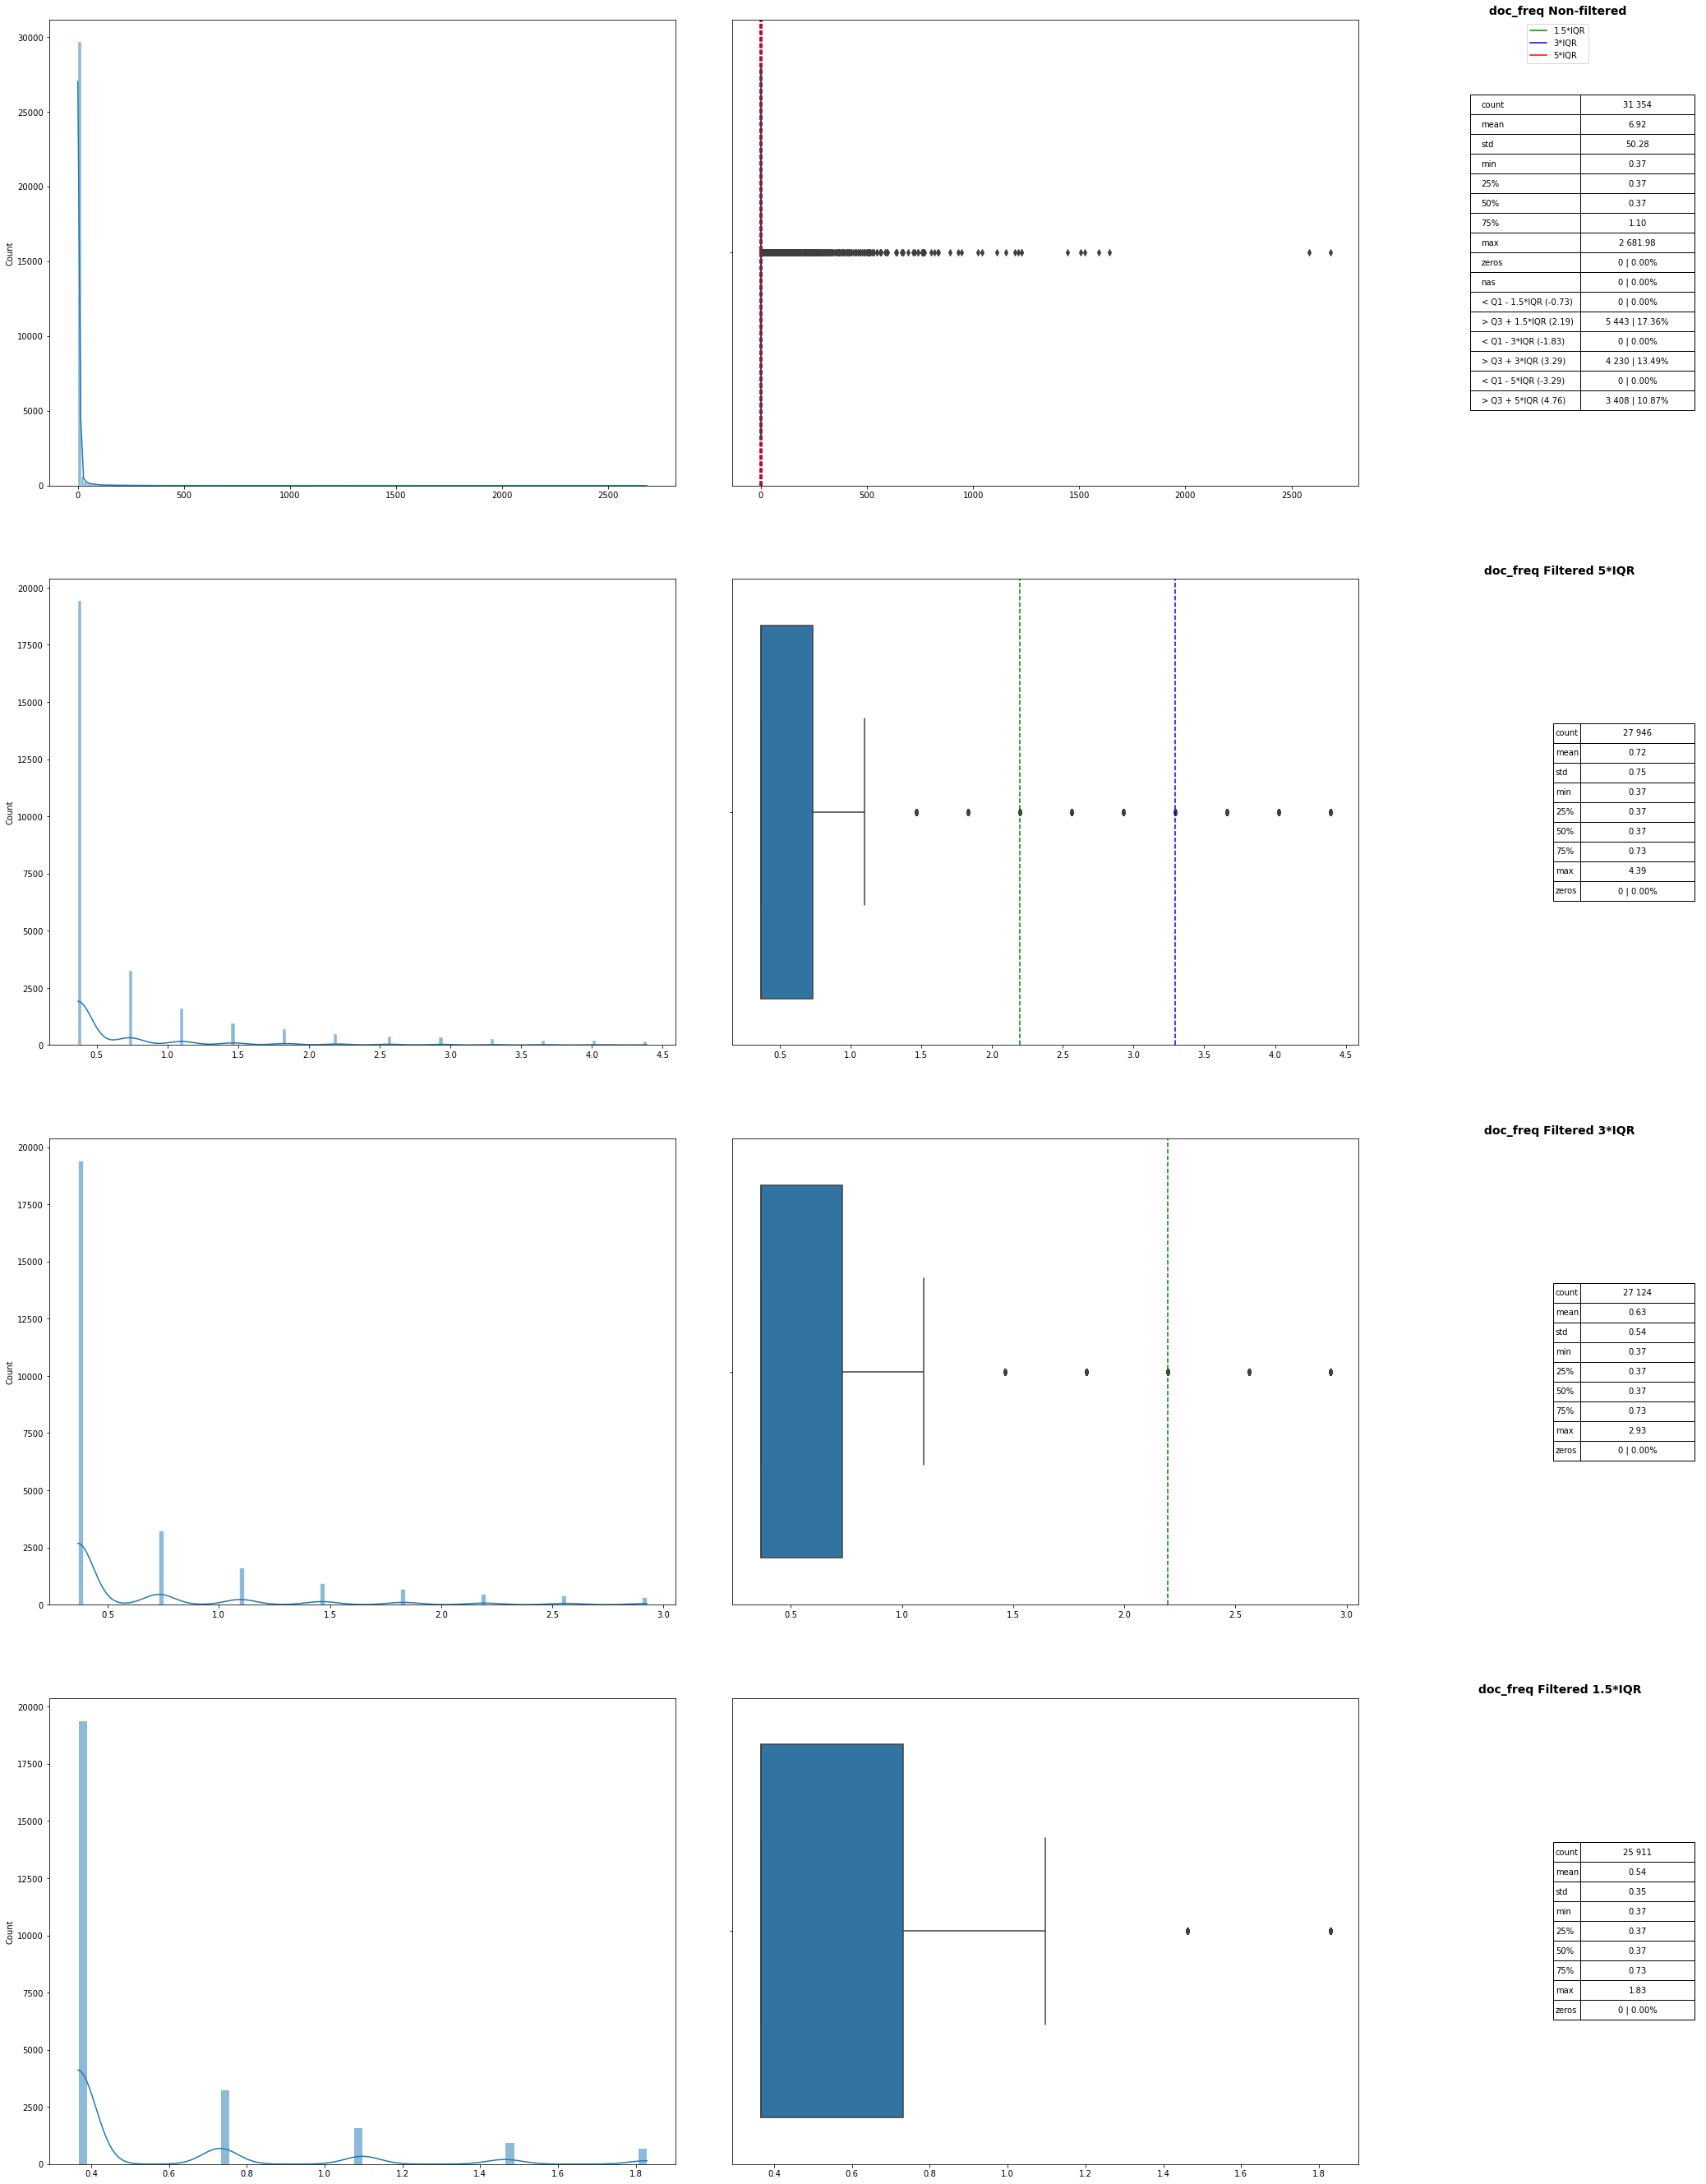

In [39]:
display_corpus_stat(data,'body-tokens','Body')

##### tokens_coverage

In [40]:
tokens_coverage(data,'body-tokens',ns=[100,500,1000])

n most used tokens  total usage  doc coverage
0                   15     0.111412      0.102120
1                   44     0.216110      0.200932
2                   89     0.320702      0.300195
3                  100     0.340170      0.319254
4                  158     0.422253      0.400983
5                  258     0.522730      0.500750
6                  414     0.620241      0.600293
7                  500     0.657970      0.638211
8                  686     0.717677      0.700174
9                 1000     0.781485      0.766055
10                1248     0.814220      0.800056
11                3083     0.909909      0.900017

##### histo_n_most_used

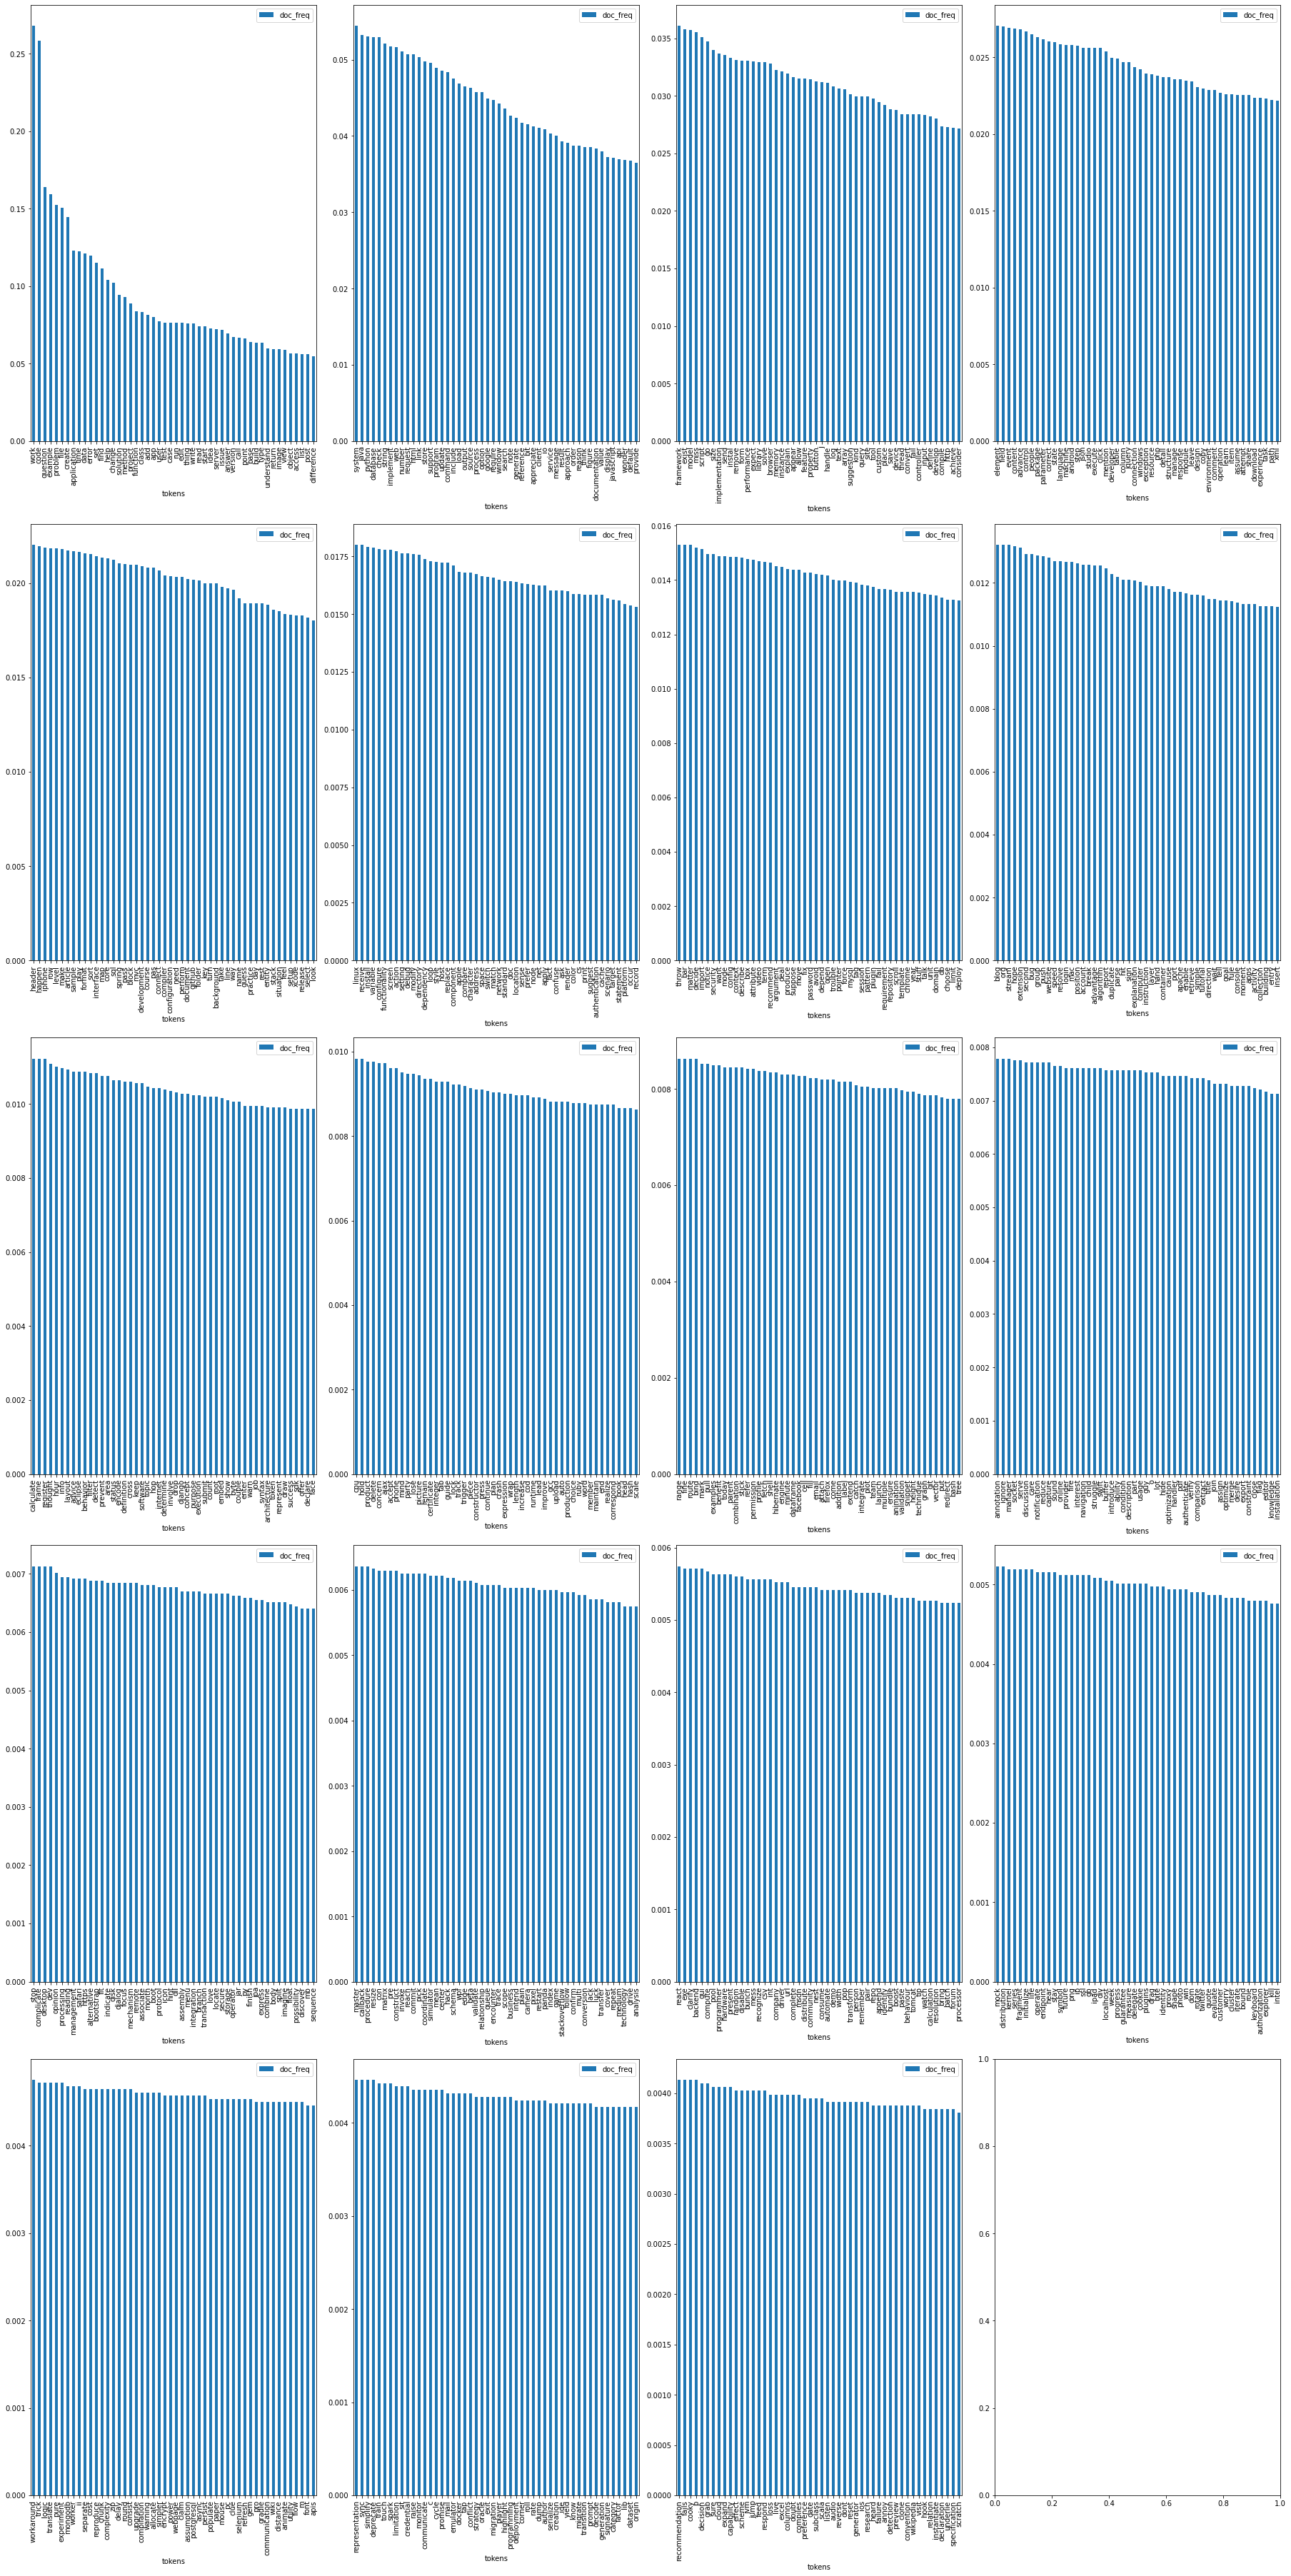

In [41]:
histo_n_most_used(data,'body-tokens',n=1000)

##### max/min doc frequencies

In [42]:
df_docCount_nmost_used(data,'body-tokens',[50-1,257+1,684+1])

n most used tokens  doc_freq  doc count
62                    49  0.054576     1492.0
498                  258  0.017631      482.0
2713                 685  0.005999      164.0

##### display_word_cloud

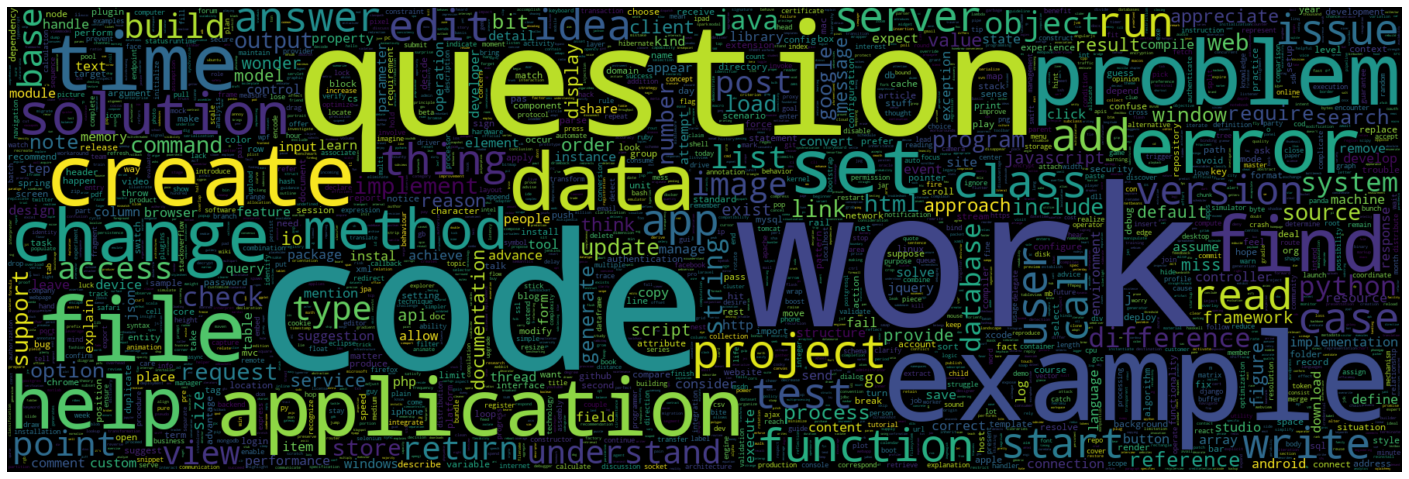

In [43]:
display_word_cloud(data,'body-tokens')

In [44]:
n_tokens = n_most_used_tokens(100,data,'body-tokens')
n_tokens[45:55]

tokens  doc_freq
189      object  0.056734
384      access  0.056551
188        list  0.056112
105        post  0.056039
62   difference  0.054576
275      system  0.054466
513        java  0.053259
329      python  0.053076
47     database  0.053003
202       check  0.053003

In [45]:
n_tokens = n_most_used_tokens(710,data,'body-tokens')
n_tokens[680:690]

tokens  doc_freq
958          camera  0.006036
959           pixel  0.006036
1863        restart  0.005999
2339          panda  0.005999
2713          index  0.005999
3273           game  0.005999
32    stackoverflow  0.005962
178          follow  0.005962
2153        confirm  0.005962
467           multi  0.005926

#### Body tokens without verbs

In [46]:
# create tokens
data['body-tokens-wov'] = pipe(
    data,
    [ 
        make_keys_getter(exclude=['code']), 
        lower_list,
        make_remove_signs_list(signs=common_signs,rpl=" ",exceptions=exceptions),
        make_tokenizer_list('\\s+'),
        make_remove_patterns_list(patterns=common_pattern,rpl=""),
        filter_empty_list,
        make_filter_list(exclude=__STOPWORDS__),
        make_lemmatizer(allowed_postags=['NN','NNS','NNP','NNPS']),
        filter_empty_list
    ],
    col='contents'
)

##### Body tokens without verbs stats

===== Document frequencies of Body corpus' tokens =====
Body corpus contains 26996 tokens.
One doc freq is 0.0037 (%).
           doc_freq
count  26996.000000
mean       0.059563
std        0.439026
min        0.003658
25%        0.003658
50%        0.003658
75%        0.010974
max       24.650669


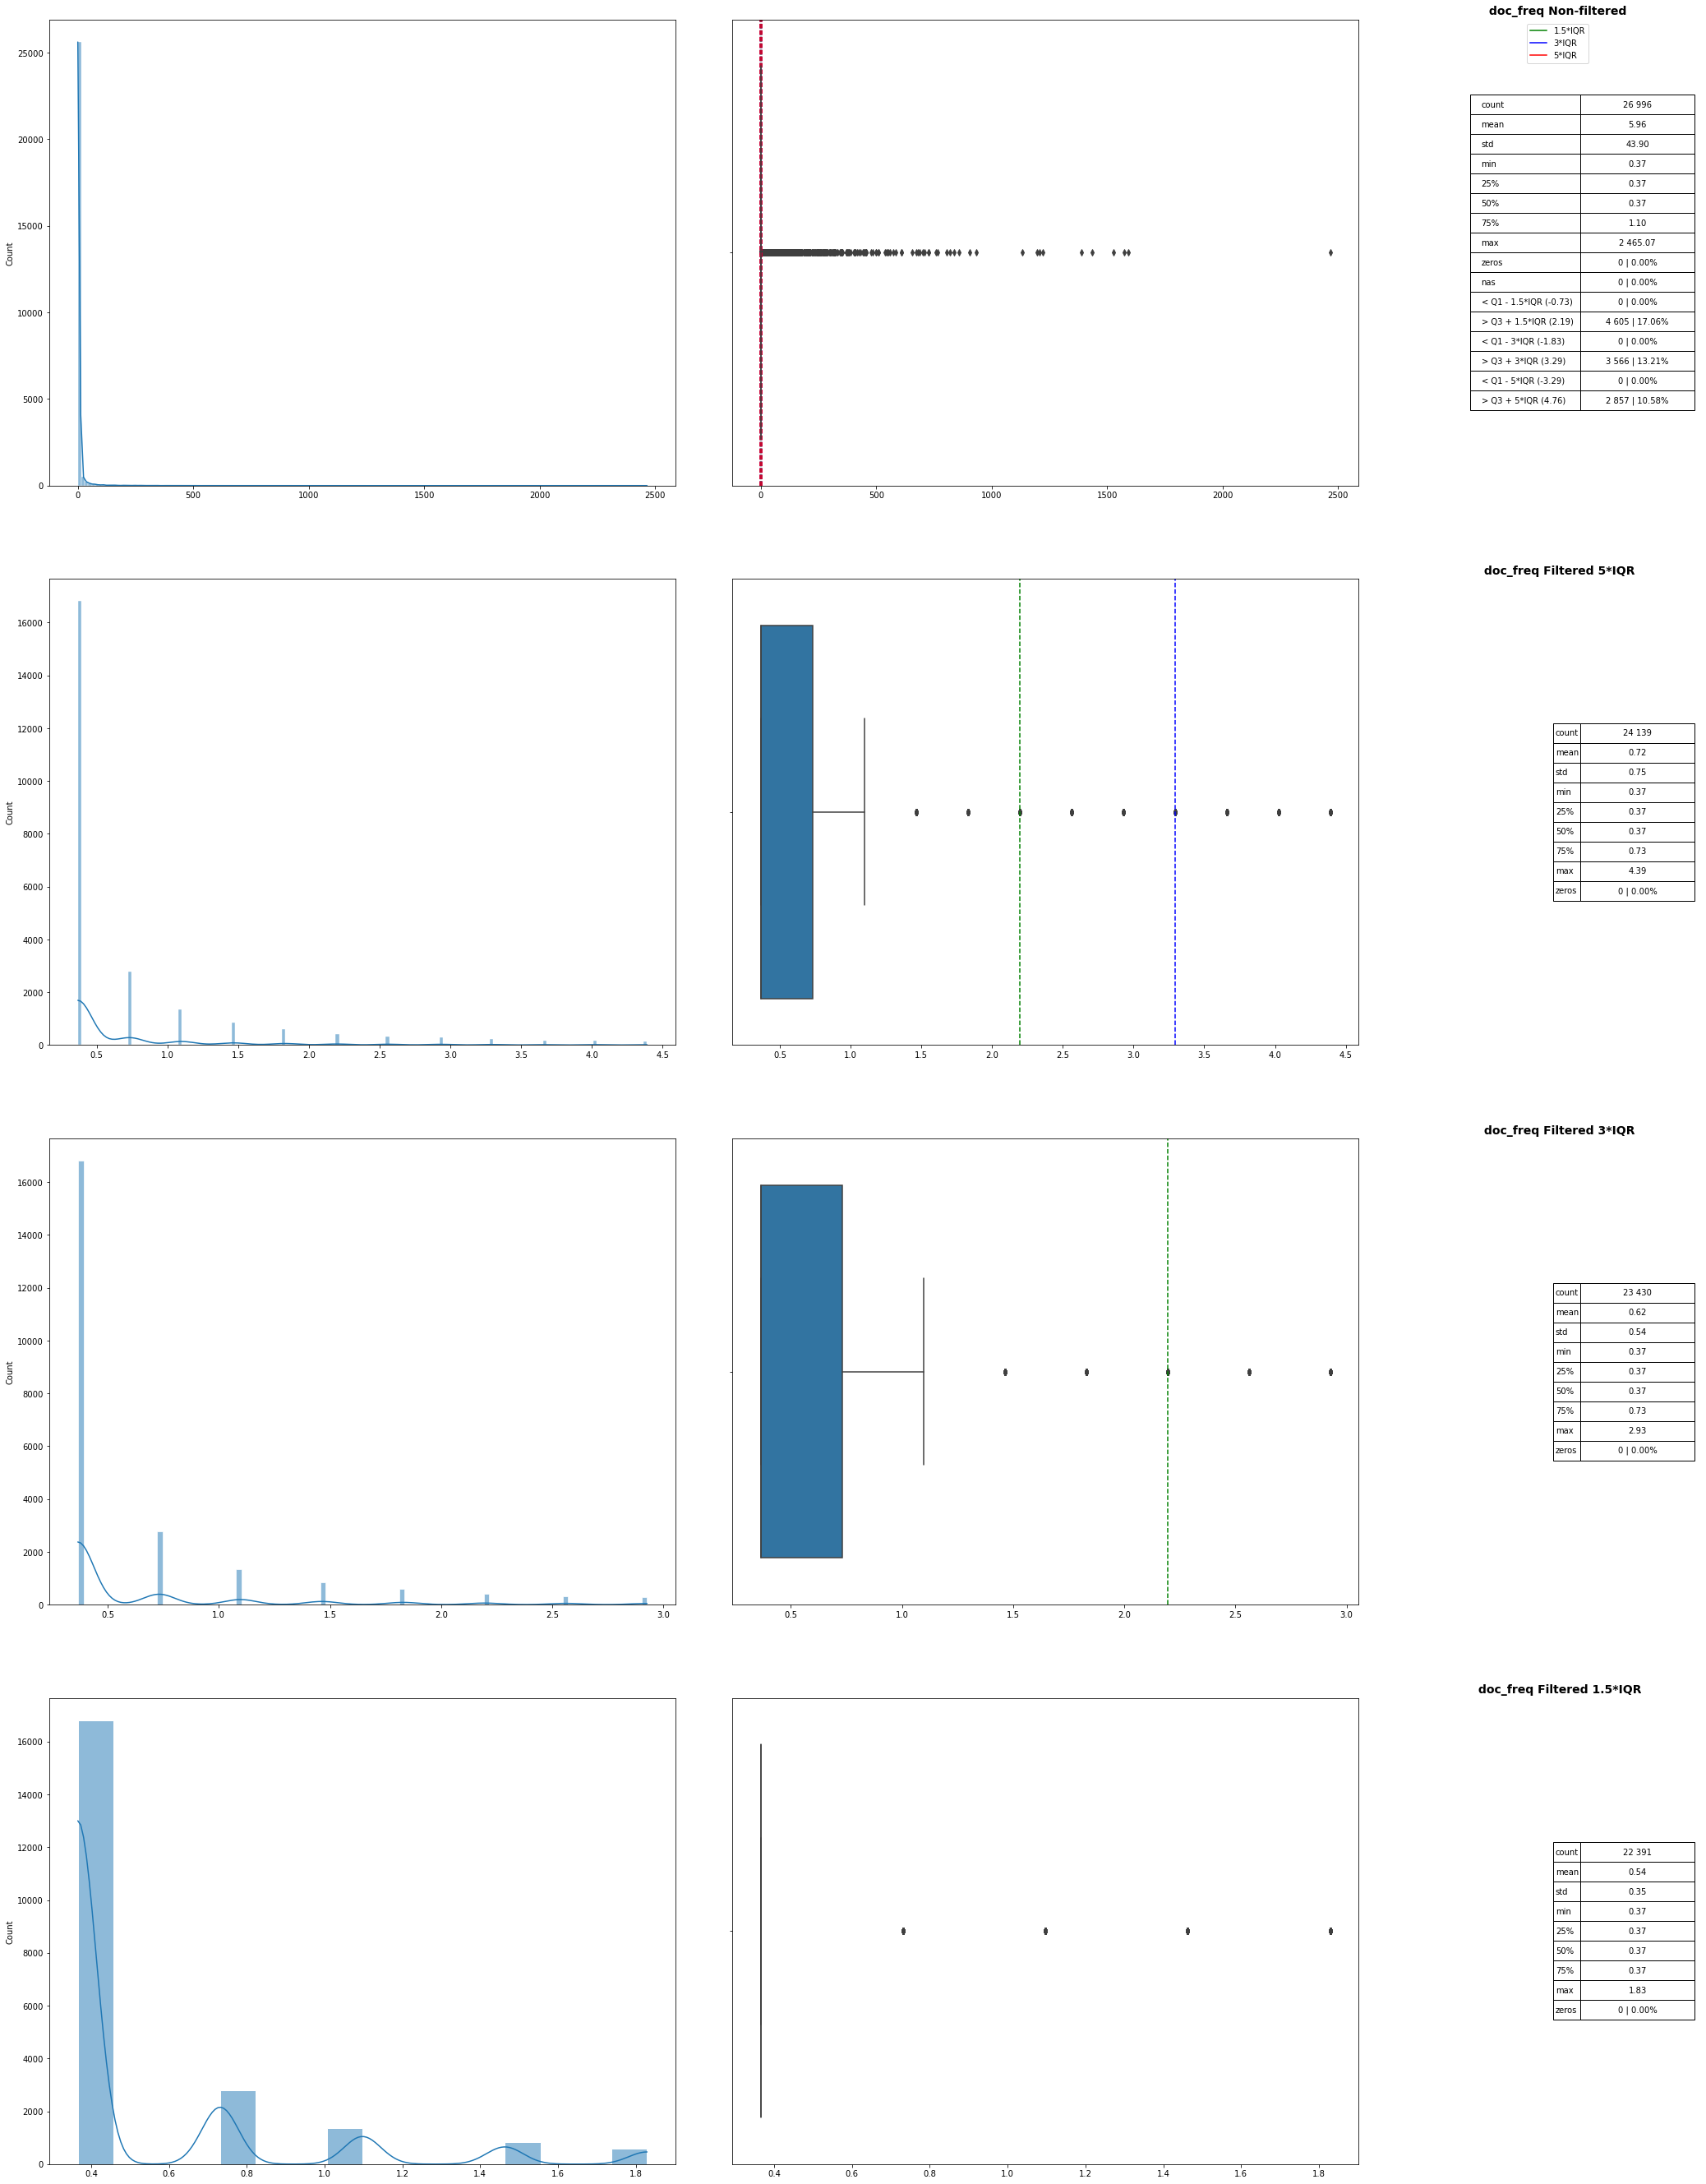

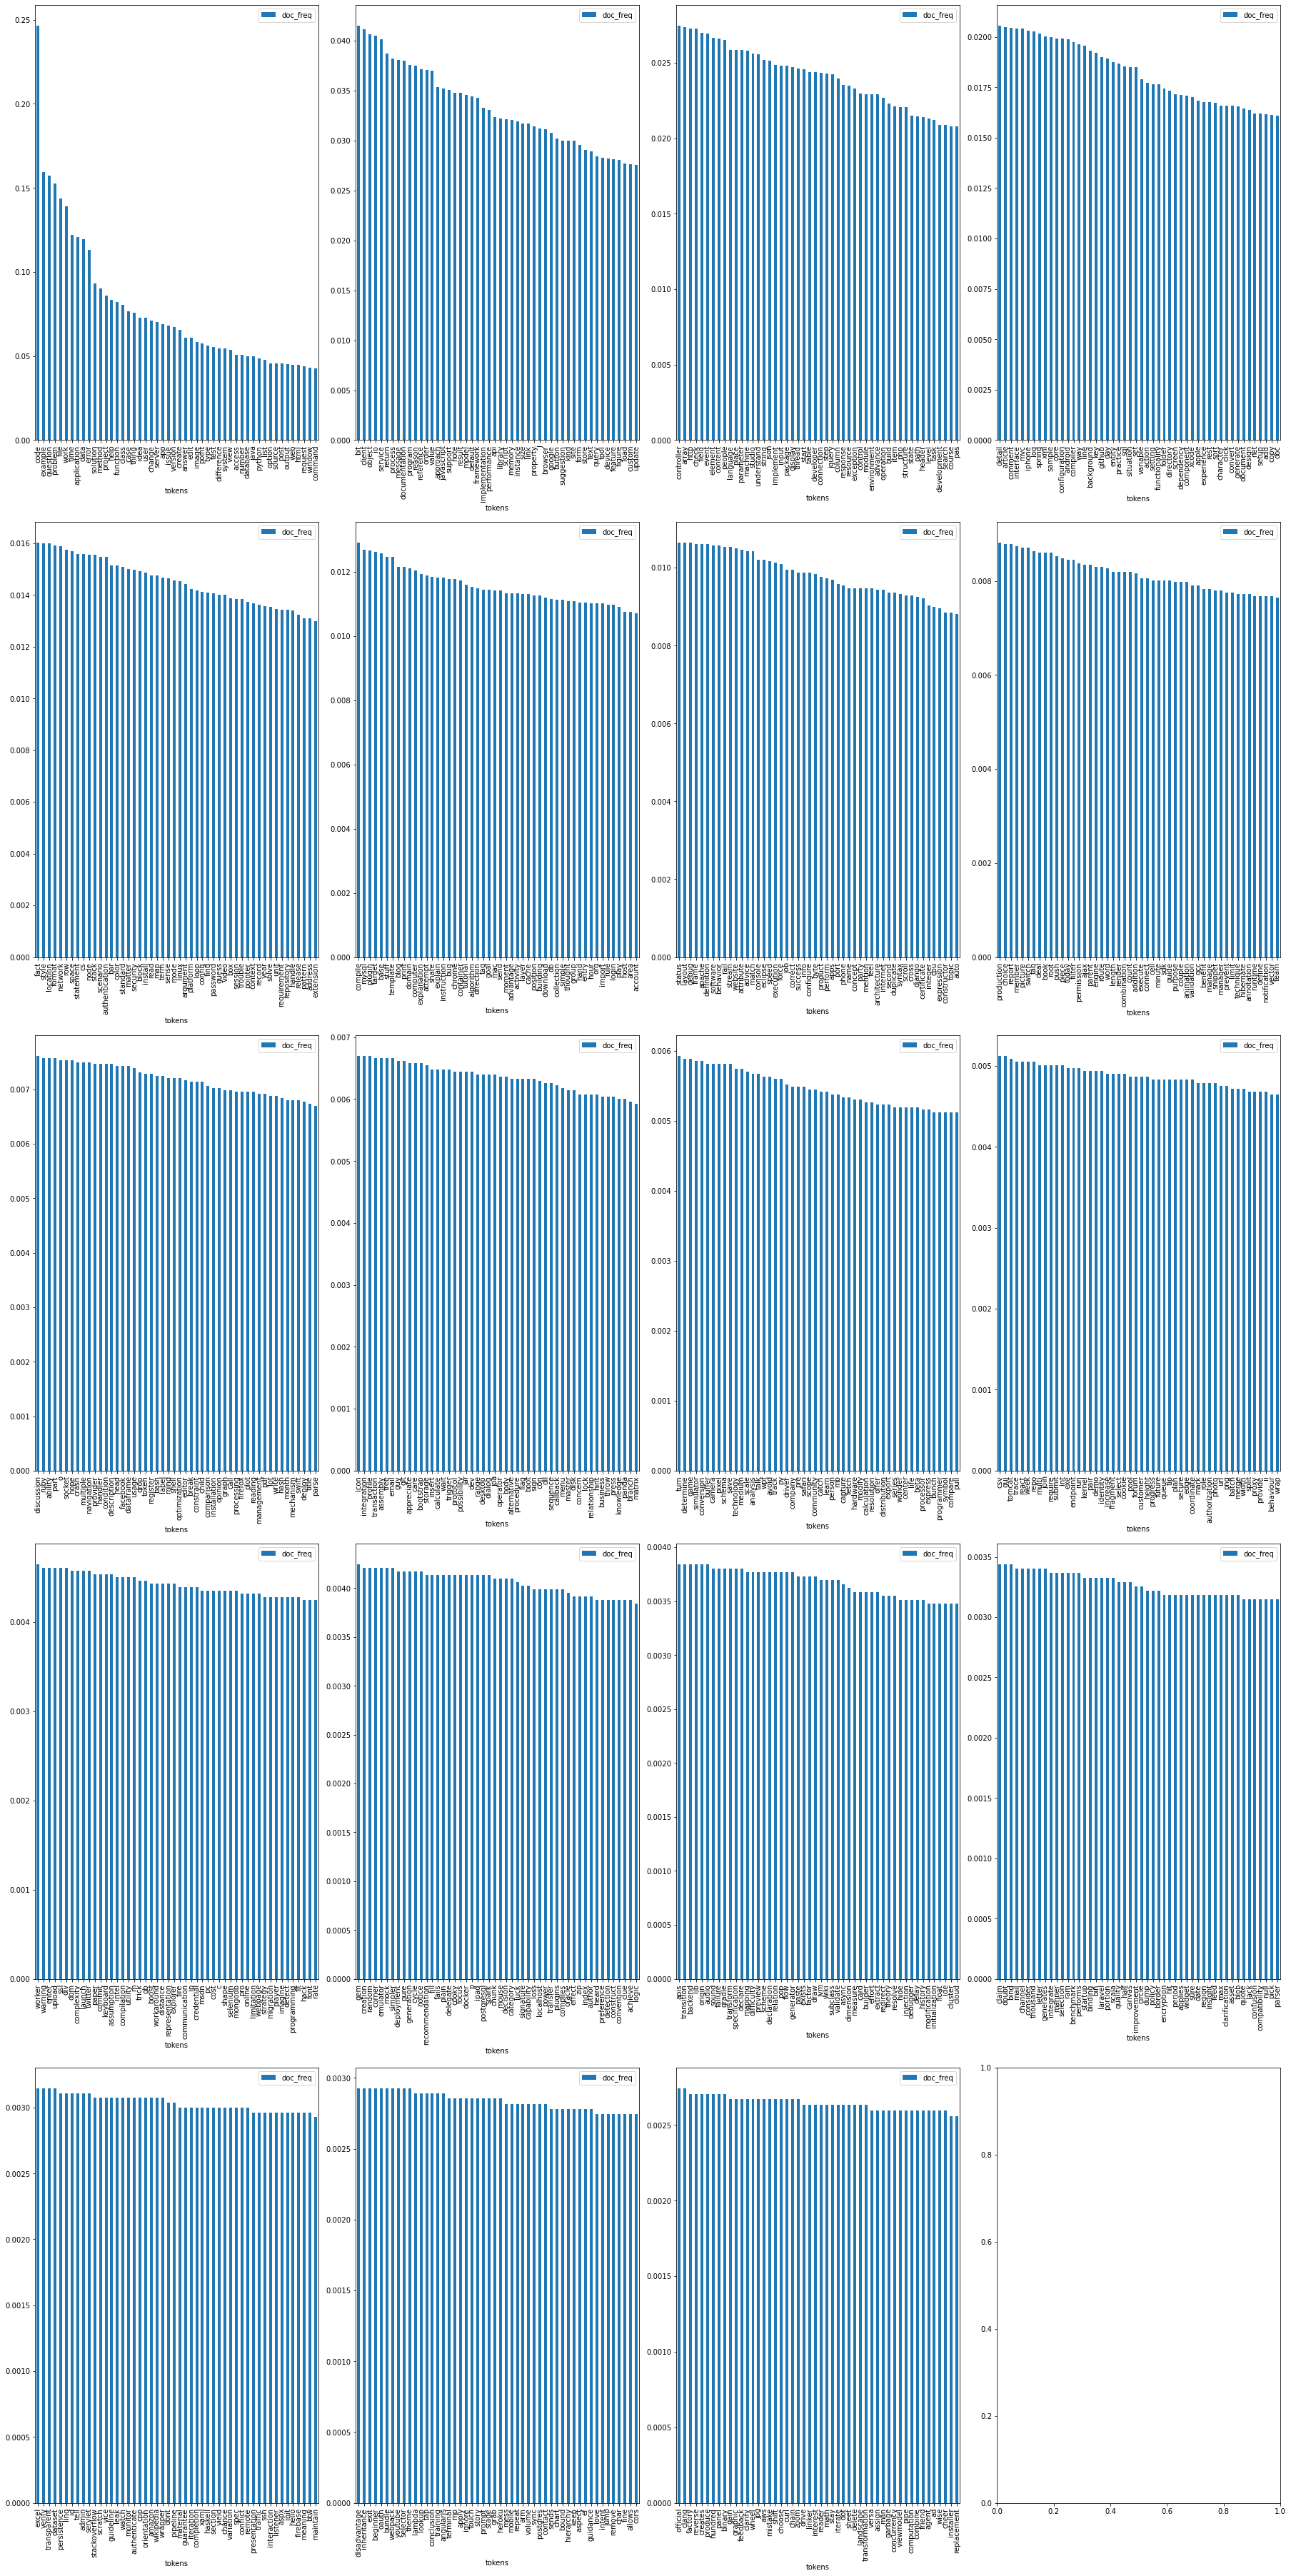

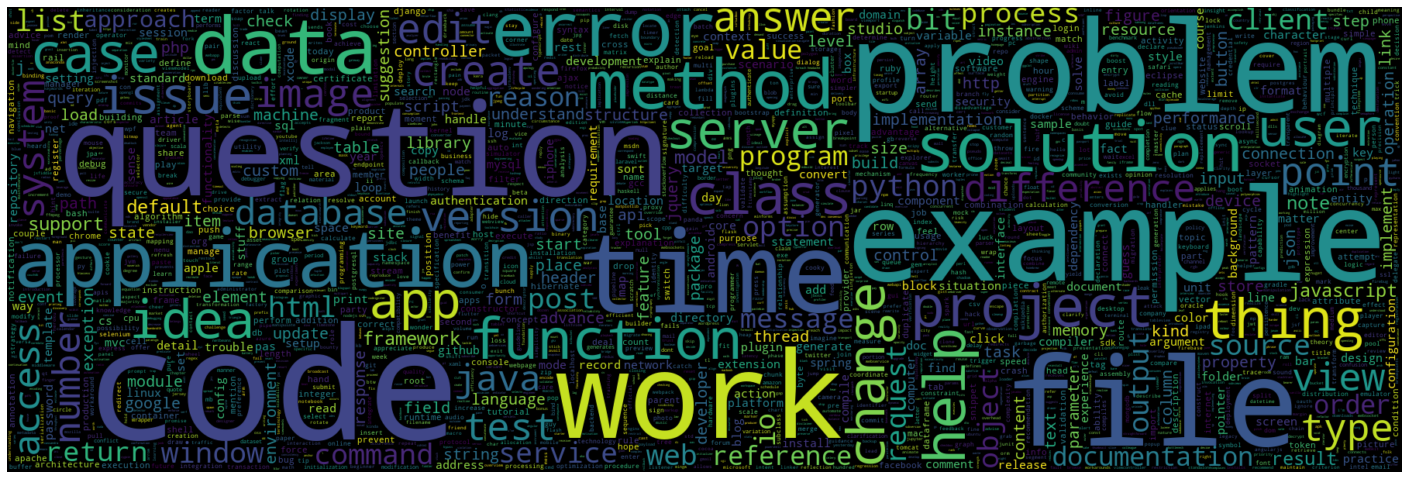

In [47]:
display_corpus_stat(data,'body-tokens-wov','Body')
histo_n_most_used(data,'body-tokens-wov',n=1000)
display_word_cloud(data,'body-tokens-wov')

##### Filter body without verbs

In [48]:
data['body-tokens-wov'] = data['body-tokens-wov'].apply(make_filter_list(exclude=['code','question','problem','data','help','thing','idea','imagine']))

##### tokens_coverage

In [80]:
tokens_coverage(data,'body-tokens-wov',ns=[100,500,1000])

n most used tokens  total usage
0                   15     0.112586
1                   44     0.220857
2                   89     0.325561
3                  100     0.346290
4                  153     0.427924
5                  249     0.527544
6                  408     0.626465
7                  500     0.665259
8                  696     0.723387
9                 1000     0.780268
10                1320     0.818705
11                3390     0.912422

In [81]:
df_docCount_nmost_used(data,'body-tokens-wov',[89+1,153+1,408+1,696+1])

n most used tokens  doc_freq  doc count
30                    90  0.027690      757.0
1165                 154  0.019899      544.0
821                  409  0.007426      203.0
1922                 697  0.003841      105.0

#### Title

#### Title tokens

In [51]:
data['title-tokens'] = pipe(data,
   [ 
      lambda x: re.compile('\\s+').split(x),
      make_remove_patterns_list(patterns=common_pattern,rpl=""),
      lower_list,
      make_remove_signs_list(signs=common_signs,rpl=" ",exceptions=exceptions),
      make_tokenizer_list('\\s+'),
      filter_empty_list,
      make_filter_list(exclude=__STOPWORDS__),
      make_lemmatizer(),
      filter_empty_list
   ],
   col='Title'
)

#### Title stats

##### display_corpus_stat

===== Document frequencies of Title corpus' tokens =====
Title corpus contains 9926 tokens.
One doc freq is 0.0037 (%).
          doc_freq
count  9926.000000
mean      0.041884
std       0.166598
min       0.003658
25%       0.003658
50%       0.003658
75%       0.018290
max       4.901602


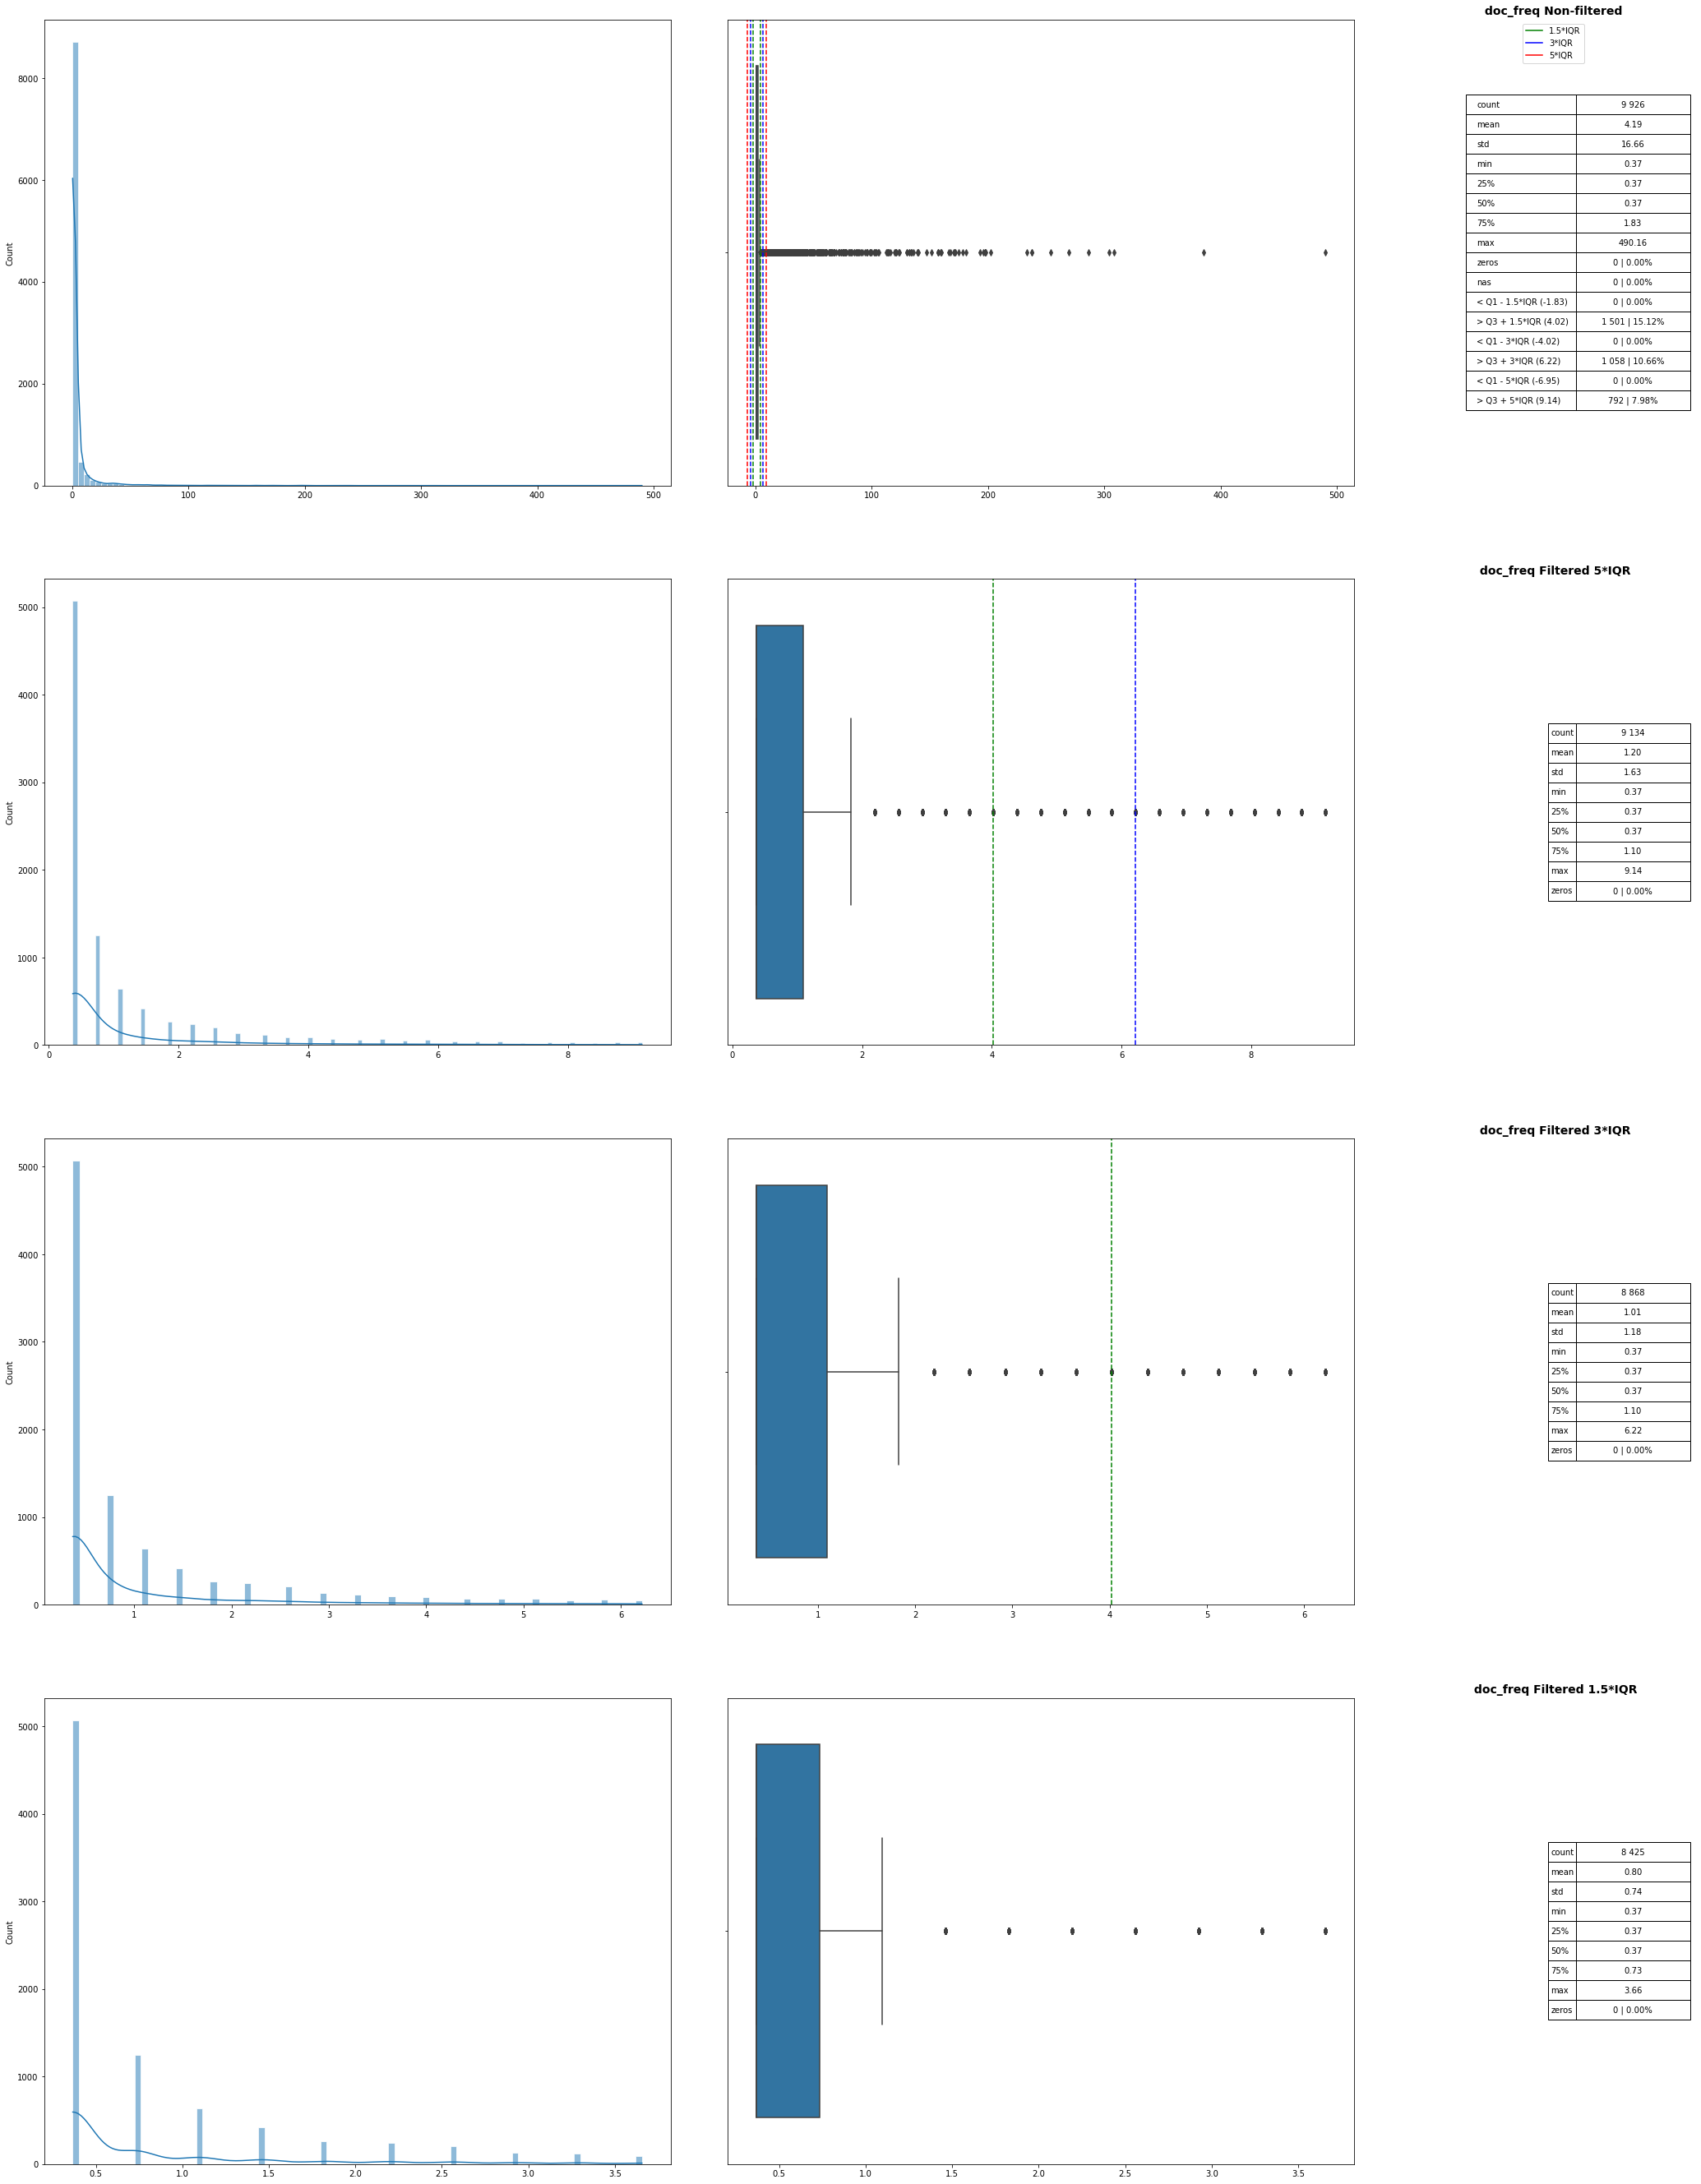

In [52]:
display_corpus_stat(data,'title-tokens','Title')

##### tokens_coverage

In [53]:
tokens_coverage(data,'title-tokens',ns=[50,100,500,1000])

n most used tokens  total usage  doc coverage
0                   16     0.101162      0.100779
1                   44     0.203077      0.201417
2                   50     0.219913      0.218380
3                   87     0.302550      0.300664
4                  100     0.325773      0.323875
5                  152     0.403095      0.400994
6                  247     0.502473      0.500119
7                  393     0.602769      0.600308
8                  500     0.651159      0.648700
9                  653     0.702627      0.700013
10                1000     0.778209      0.775927
11                1161     0.802195      0.800097
12                2509     0.901393      0.900022

##### histo_n_most_used

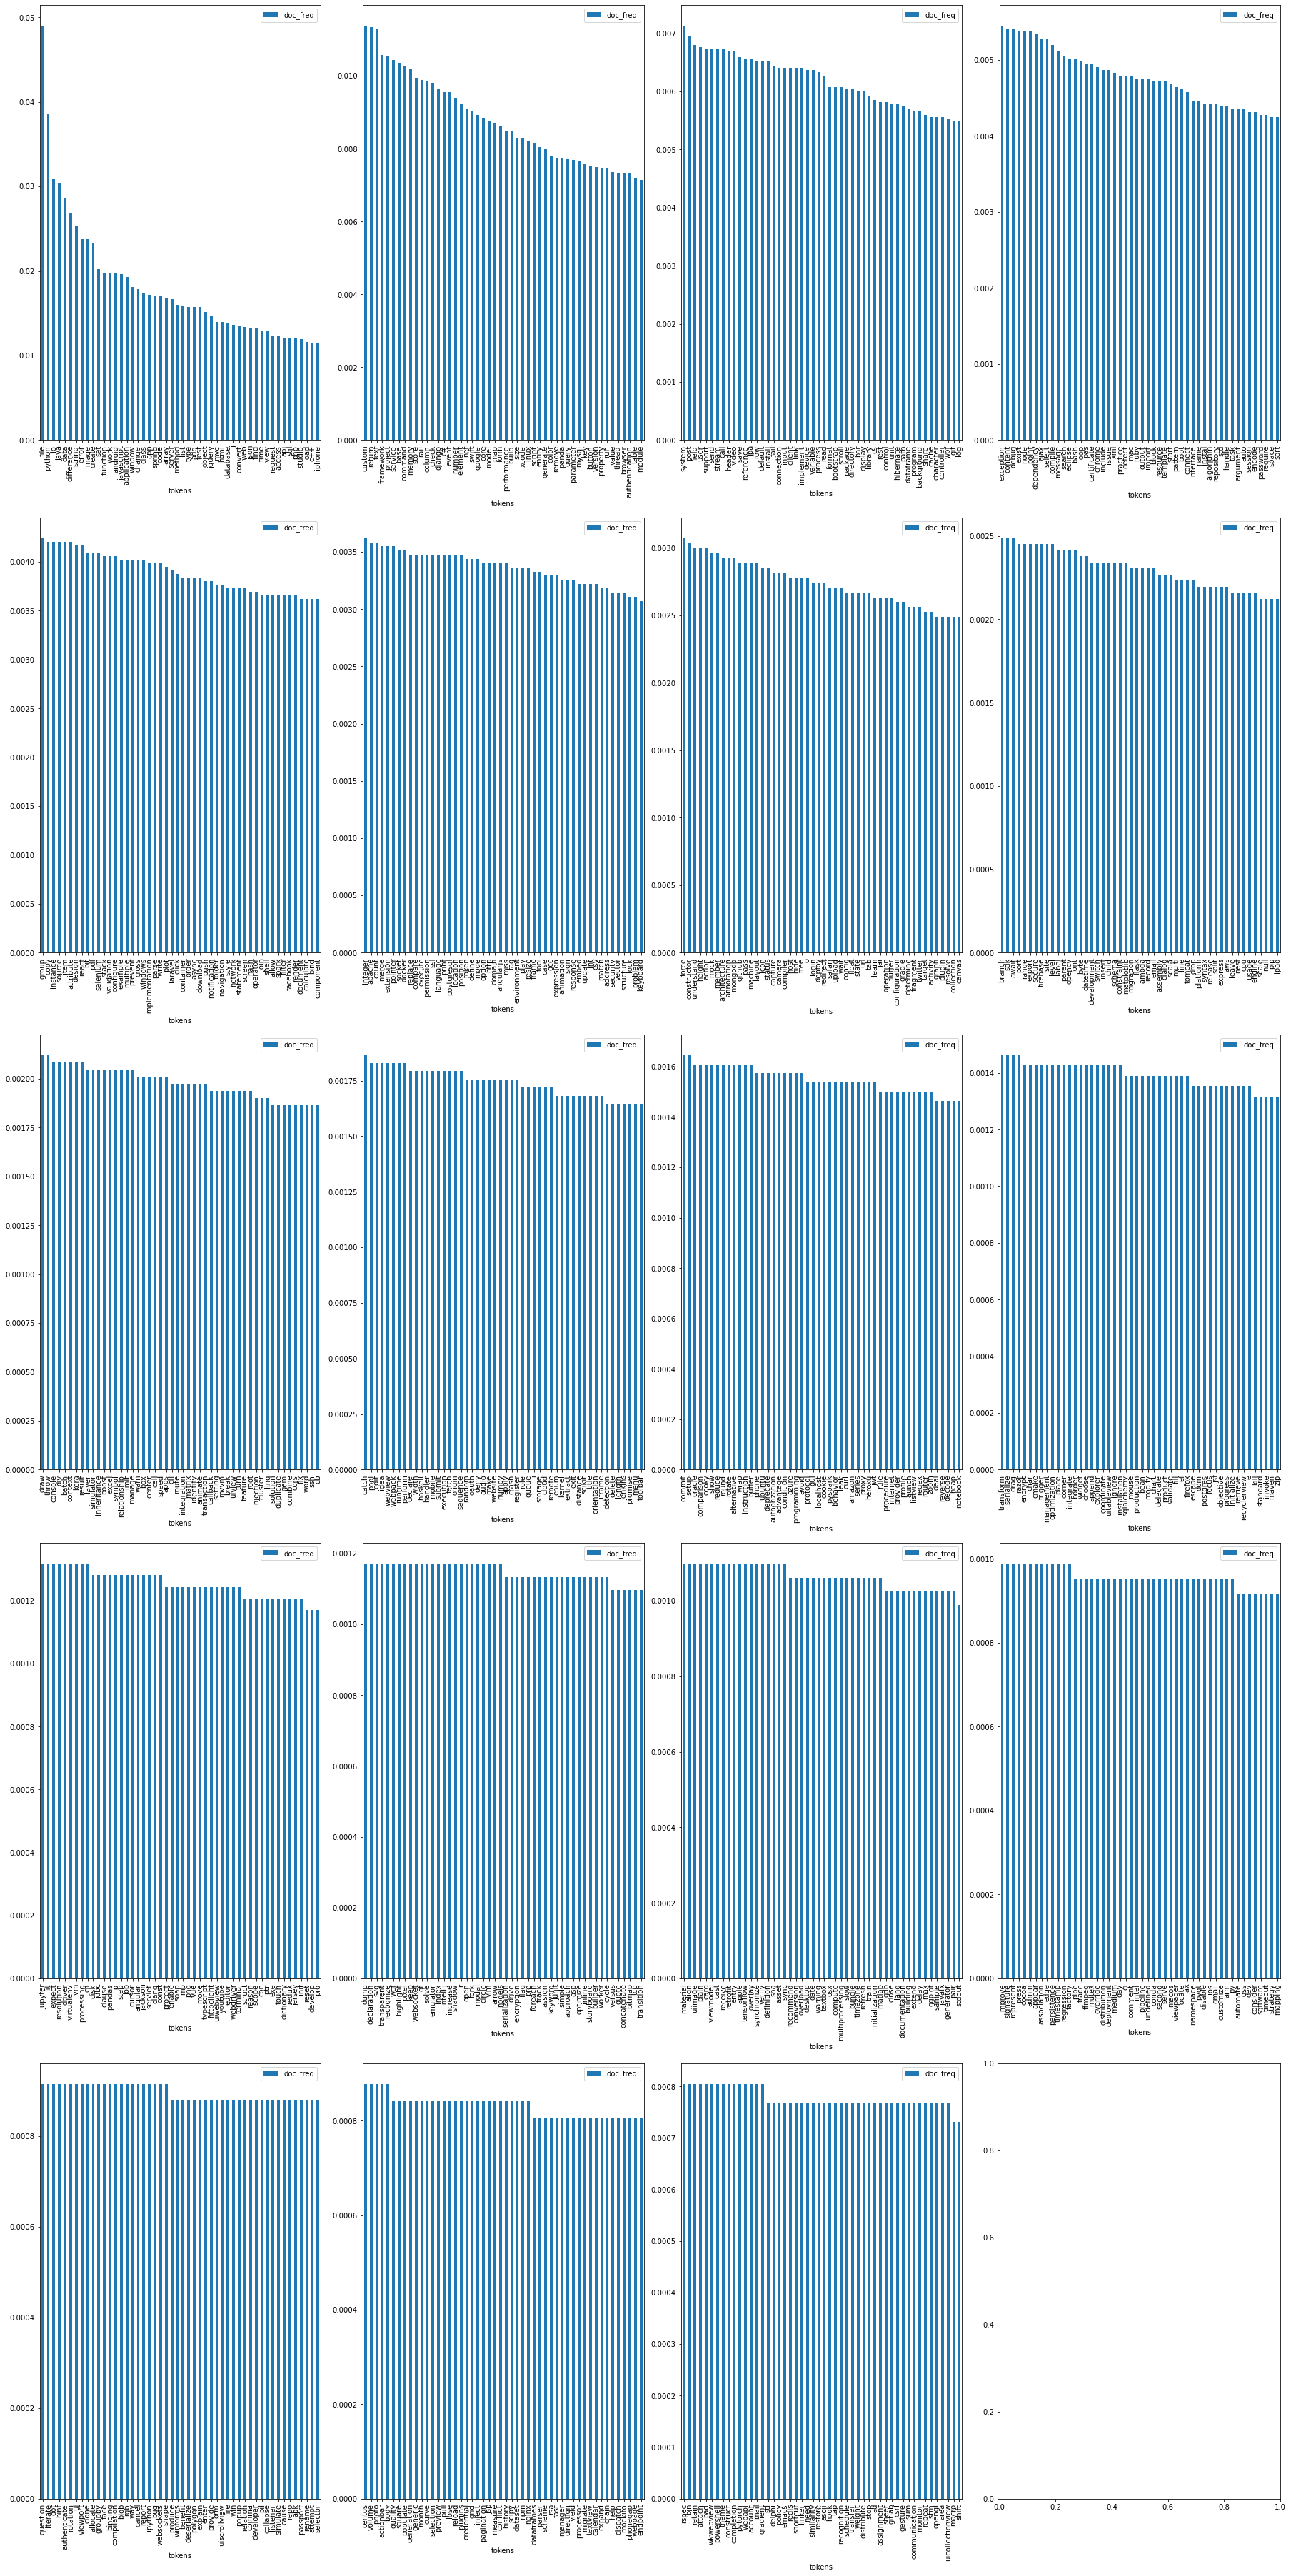

In [54]:
histo_n_most_used(data,'title-tokens',n=1000)

##### min doc frequencies

In [55]:
df_docCount_nmost_used(data,'title-tokens',[87+1,152+1,393+1])

n most used tokens  doc_freq  doc count
18                    88  0.007645      209.0
1083                 153  0.005377      147.0
465                  394  0.002158       59.0

##### display_word_cloud

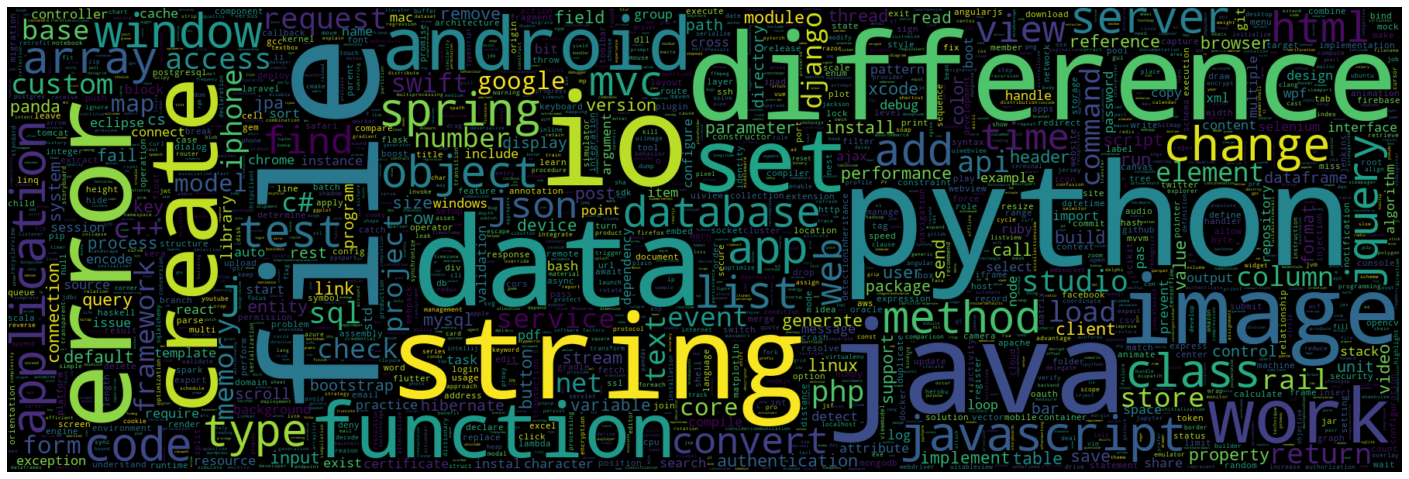

In [56]:
display_word_cloud(data,'title-tokens')

In [57]:
titles = n_most_used_tokens(1000,data,'title-tokens')
titles[0:25]

tokens  doc_freq
34          file  0.049016
56        python  0.038518
38            io  0.030836
144         java  0.030434
569         data  0.028605
21    difference  0.026922
167       string  0.025386
29         error  0.023776
347        image  0.023776
102       create  0.023301
43           set  0.020228
464     function  0.019826
122         work  0.019716
207      android  0.019716
63    javascript  0.019606
151  application  0.019314
86        window  0.018070
58        change  0.017814
73         class  0.017448
520          app  0.017156
251       spring  0.017119
105         code  0.017046
330        array  0.016753
5         server  0.016643
263       method  0.015985

In [58]:
titles[25:50]

tokens  doc_freq
31       list  0.015875
7        type  0.015729
94        add  0.015729
139      test  0.015729
142    object  0.015144
45     jquery  0.014705
172       mvc  0.014010
85       html  0.013937
14   database  0.013900
327         j  0.013607
181   convert  0.013461
437       web  0.013351
859      json  0.013242
125      find  0.013205
217      time  0.012986
805      view  0.012986
59    request  0.012364
98     access  0.012291
832       api  0.012108
0         sql  0.012071
131       php  0.011998
123    studio  0.011925
243      load  0.011596
231       c++  0.011486
551    iphone  0.011449

#### Filter titles

In [59]:
data['title-tokens'] = data['title-tokens'].apply(make_filter_list(exclude=['code','data']))

### Save results

In [60]:
data.to_csv(f'{path}/{results}')

#### <s>Debug</s>

In [61]:
# def dump(id,df,cols=['Title','Body','title-tokens','contents','body-tokens','filtered-body-tokens','code-language','tokens','Tags','ntags'],id_col='Id'):
#     cols = list(filter(lambda x: x in df.columns,cols))
#     print(f">>> Id: {id} <<<")
#     data = df[df[id_col] == id]
#     with pd_context({'display.max_columns':None,'display.max_rows':100,'display.max_colwidth':None}):
#         _ = list(map(lambda c: print(f"{c}:\n{data[c].to_string(header=False,index=False)}\n====="),cols))

In [62]:
# Ids = [22168819,5360795,33585225,149336,499247]
# index = data[data.Id.isin(Ids)].index
# data = data.loc[index,:]
# for id in Ids:
#      dump(id,data)

### PCA analysis

body_min: 0.005998975784622138 - body_max: 0.05457604799180628 - title_min: 0.0021215889970005123 - title_max: 1.0
pca.shape: (27338, 711)


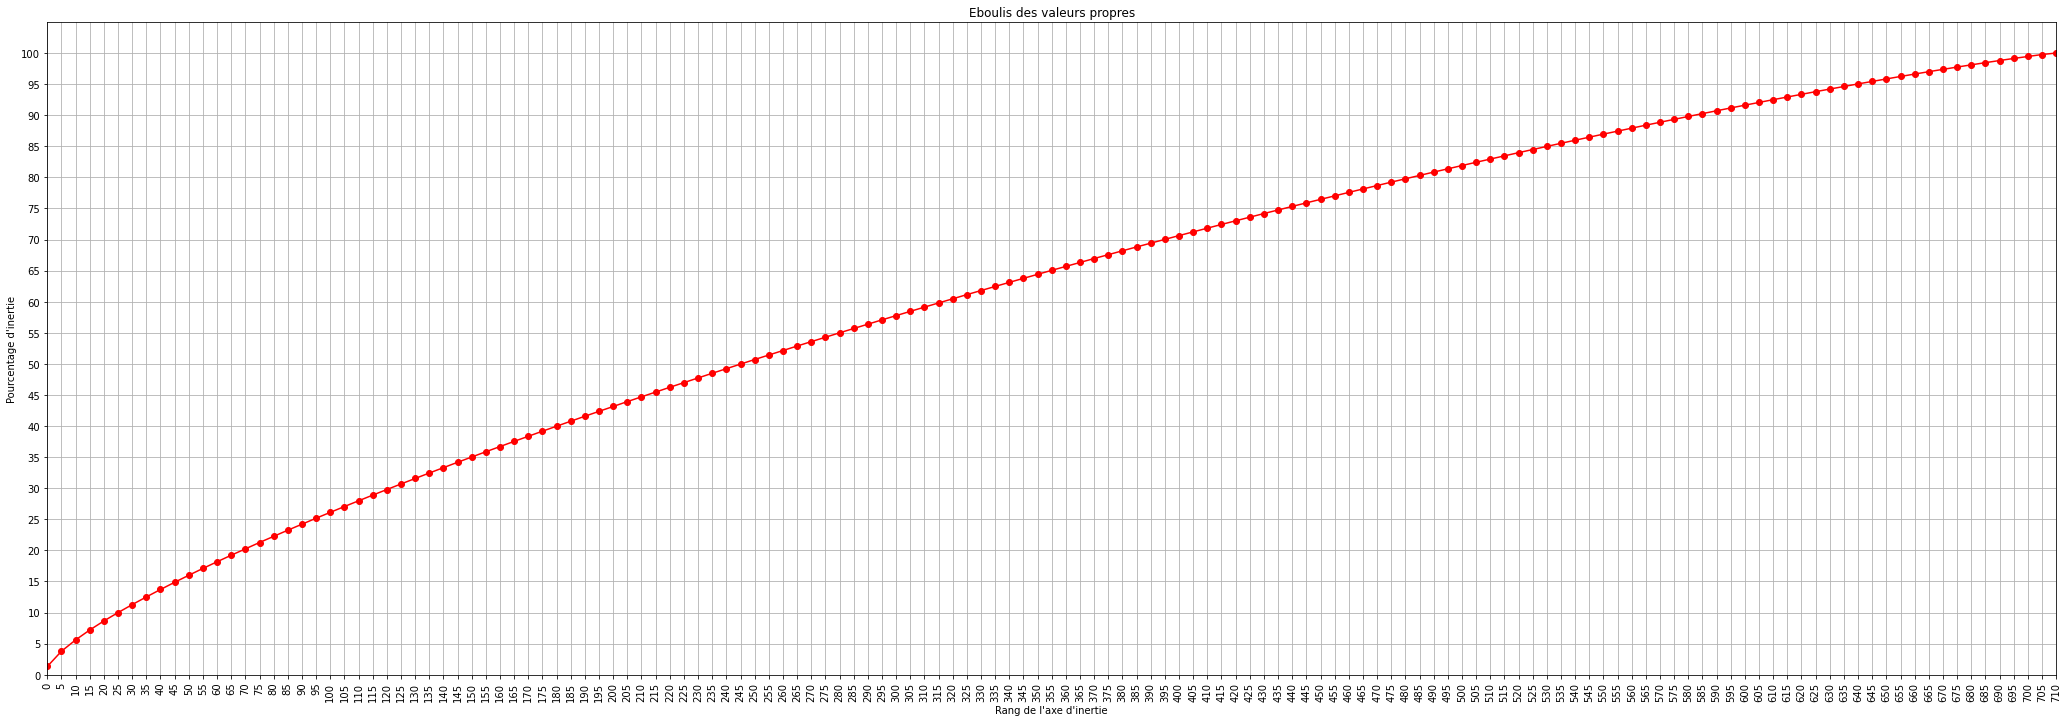

In [63]:
display_pca(data,body_min=164*one_doc,body_max=1492*one_doc,title_min=58*one_doc,title_max=1.0)

body_min: 0.017631136147487014 - body_max: 0.05457604799180628 - title_min: 0.007535298851415613 - title_max: 1.0
pca.shape: (27338, 244)


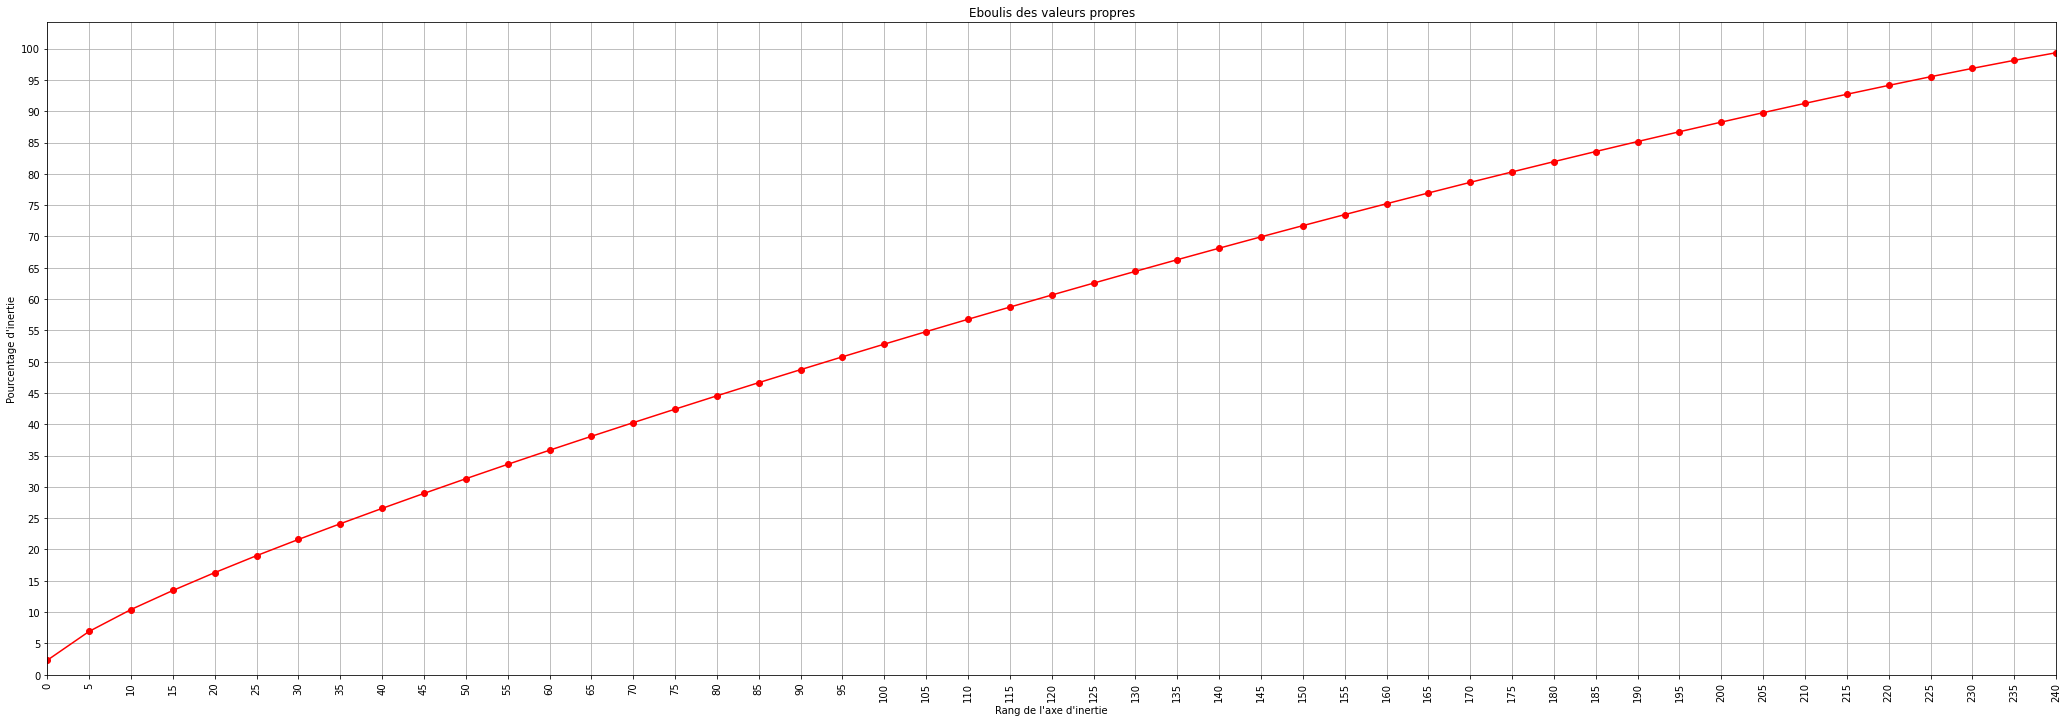

In [64]:
display_pca(data,body_min=482*one_doc,body_max=1492*one_doc,title_min=206*one_doc,title_max=1.0)

body_min: 0.003840807666983686 - body_max: 1.0 - title_min: 0.0021215889970005123 - title_max: 1.0
pca.shape: (27338, 730)


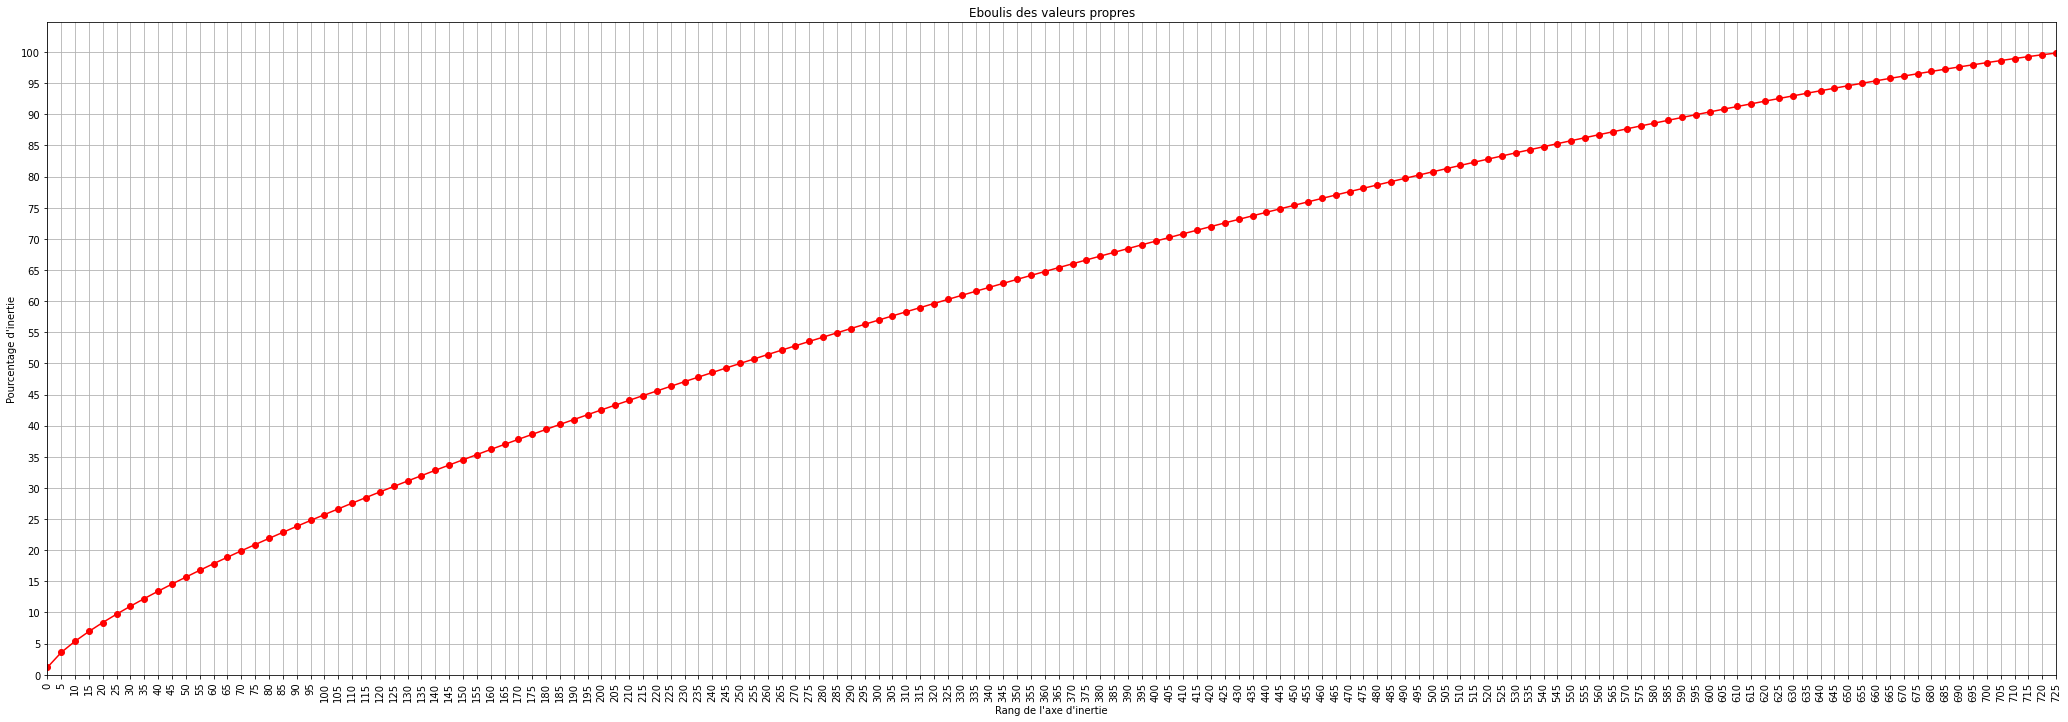

In [65]:
display_pca(data,body_min=105*one_doc,body_max=1.0,title_min=58*one_doc,title_max=1.0,col_body='body-tokens-wov')